# Assignment 3: Score Based Generative Modeling Through Stochastic Differential Equations

In this assignment, you will be implementing architectures seen in the paper Scored Based Generative Modeling Through Stochastic Differential Equations, which we saw in the tutorials connects between the two methods you have already implemented. Due to this already being the third assignment, there will be less guidance throughout the exercise and you will have more of a free hand. Remember to turn off machines when you're not using them, and to frequently save checkpoints of your models!

The free hand means that documentation is important. We expect non-trivial functions to be documented. Additionally, we expect (brief) explanations in the notebook of how you chose to implement each part of the assignment. Good luck!

## Submission Guidelines

- If it is more comfortable, you may submit either a python project with several files which define functions or a single python notebook that implements everything. The python notebook should include outputs, even if they are not the same outputs as the ones you submit in the zip.
- If you choose to submit using a python project, you must also submit a notebook that runs all relevant functions and generates all outputs (they don't need to be the same as the ones that are in the visualization zip, but we should be able to see that all functions run correctly). There should be two zips in this case: one containing all code files (including the notebook that replicates the outputs) and another containing the visualizations as done before.
- You may name the zip files as you wish, as long as your ID is in the name.
- All other requirements are based on the requirements in the syllabus.
- Reminder: You can play with the functions as much as you want to, and don't need to implement functions using the same parameters / names as what we provide. All changes that you make should be documented and should still do all the things you're required to do.

In [ ]:
import torch
import torch.nn as nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from tqdm import tqdm
import math
from inspect import isfunction
from functools import partial
%matplotlib inline
import matplotlib.pyplot as plt
from einops import rearrange
import os
from collections import Counter
from torch.optim import Adam
from torchvision.utils import save_image
from pathlib import Path
from datasets import load_dataset

## Part 1.1: Visualizing SDEs Using Simulations

In this part, we will recreate part of Figure 2 in https://arxiv.org/pdf/2011.13456 using Euler's method for sampling from SDEs. In particular, we will be recreating the Variance Preserving SDE (DDPM's continuous form):

$$
d\textbf{x}_t = -\frac{1}{2}\beta_t \textbf{x}_t dt + \sqrt{\beta_t} d\textbf{w}_t
$$

Note that in the paper, Figure 2 is of the ALD based SDE, so it looks different than what you will be creating. Throughout this part of the assignment, we will be working with $\beta_0 = 0.1, \beta_1 = 20$, $\beta(t) = (\beta_1 - \beta_0)t + \beta_0$. $\mathbf{x}_0$ follows a mixture of Gaussians distribution, with probability 0.5 of being centered around -3 and 0.5 of being centered around 3, with standard deviation 0.5.

This part can be entirely run on your PC, without needing the VM or CUDA. We strongly recommend to run this part of the assignment locally. 

1. For $\textbf{x} \in \mathbb{R}$, formulate the ground truth distribution $p_t(\textbf{x}_t | \textbf{x}_0)$ and the function $\nabla_{\textbf{x}_t} \log p_t(\textbf{x}_t | \textbf{x}_0)$. Note $\Sigma_0 = 0$.
2. Train a simple model using the loss from tutorials 5/6 to approximate the marginal score: $\nabla_{\textbf{x}_t}\log p_t(\textbf{x}_t)$, for the above SDE.
3. Sample 100,000 values for $\textbf{x}_0$ following a mixture of Gaussians, probability 0.5 of being centered around -3 and 0.5 being centered around 3, with standard deviation 0.5. Advance them according to the SDE provided in DDPM, using Euler's method with `T=1000` and step size `1e-2`. What is the distribution we reached?
4. For 10,000 random starting points, advance them according to the probability flow ODE, using the score you learned. Note that despite the fact that you need the score to do this, *you are still advancing the points according to the forward process*! 
5. Now, reverse the process by sampling 10,000 samples from the prior distribution and taking reverse steps according to the reverse SDE using the score. To sample using Euler in the reverse process, see equation 46 in the paper linked above (in Appendix E, $\mathbf{f}\equiv \mu, \mathbf{G}\equiv \sigma$). Display the trajectory of 2 random starting points using the reverse SDE.
6. Bonus (2 points): Sample 10,000 points according to the reverse probability flow ODE and display the trajectory of two random starting points.

## Variance Preserving SDE

$$d\mathbf{x}_t = -\frac{1}{2}\beta_t \mathbf{x}_t dt + \sqrt{\beta_t} d\mathbf{w}_t$$

Where $\beta_t = \beta_0 + (\beta_1 - \beta_0)t$

The integral of $\beta$ from $0$ to $t$ is:
$$\int_0^t \beta(s) ds = \int_0^t [\beta_0 + (\beta_1 - \beta_0)s] ds = \beta_0 t + (\beta_1 - \beta_0)\frac{t^2}{2}$$

We define $\alpha(t) = e^{-\frac{1}{2}\int_0^t \beta(s)ds} = e^{-\frac{1}{2}[\beta_0 t + (\beta_1 - \beta_0)\frac{t^2}{2}]}$

For a linear SDE like this, the conditional distribution $p_t(\mathbf{x}_t | \mathbf{x}_0)$ is Gaussian:
$$p_t(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \mu_t, \sigma_t^2)$$

Where:
$$\mu_t = \mathbf{x}_0 \alpha(t) = \mathbf{x}_0 e^{-\frac{1}{2}\int_0^t \beta(s)ds}$$
$$\sigma_t^2 = 1 - e^{-\int_0^t \beta(s)ds} = 1 - e^{-[\beta_0 t + (\beta_1 - \beta_0)\frac{t^2}{2}]}$$

The score function is the gradient of the log-likelihood:
$$\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t | \mathbf{x}_0) = -\frac{\mathbf{x}_t - \mu_t}{\sigma_t^2} = -\frac{\mathbf{x}_t - \mathbf{x}_0 \alpha(t)}{1 - e^{-\int_0^t \beta(s)ds}}$$

In [2]:
BETA_0 = 0.1
BETA_1 = 20.0

def beta_schedule(t):
    """Beta function at time t"""
    return BETA_0 + (BETA_1 - BETA_0) * t

def integral_beta(t):
    """Integral of beta from 0 to t"""
    return 0.5 * (BETA_1 - BETA_0) * t**2 + BETA_0 * t

def alpha(t):
    """Exponential decay factor"""
    return torch.exp(-0.5 * integral_beta(t))

def conditional_mean(x_0, t):
    """Mean of p(x_t|x_0)"""
    return x_0 * alpha(t)
    
def conditional_var(t):
    """Variance of p(x_t|x_0) with minimum threshold for numerical stability"""
    var = 1 - torch.exp(-integral_beta(t))
    return torch.clamp(var, min=1e-5)  # Prevent near-zero variances

def sample_conditional(x_0, t):
    """Sample from p(x_t|x_0)"""
    mean = conditional_mean(x_0, t)
    std = torch.sqrt(conditional_var(t))
    return mean + std * torch.randn_like(mean)

def score_conditional(x_t, x_0, t):
    """Score function: ∇_{x_t} log p(x_t|x_0)"""
    mean = conditional_mean(x_0, t)
    var = conditional_var(t)
    return -1.0 * (x_t - mean) / var

def sample_x0(batch_size):
    """Sample from mixture of Gaussians (initial distribution)"""
    # Randomly choose which Gaussian to sample from
    mask = torch.randint(0, 2, (batch_size,), dtype=torch.float32)
    
    # Generate samples from the selected Gaussian
    # p=0.5 centered at -3, p=0.5 centered at 3, std=0.5
    means = mask * 6 - 3  # Convert 0/1 to -3/3
    samples = means + 0.5 * torch.randn(batch_size)
    
    return samples.view(-1, 1)  # Return as [batch_size, 1]

def sample_xt_given_x0(x_0, t):
    """Sample from p(x_t|x_0)"""
    mean = conditional_mean(x_0, t)
    var = conditional_var(t)
    std = torch.sqrt(var)
    noise = torch.randn_like(x_0)
    
    # Using reparameterization trick
    x_t = mean + std * noise
    
    # Save the noise for loss computation
    return x_t, noise

def true_score_conditional(x_t, x_0, t):
    """Score function: ∇_{x_t} log p(x_t|x_0)"""
    mean = conditional_mean(x_0, t)
    var = conditional_var(t)
    return -1.0 * (x_t - mean) / var

# Part 1.2

Training Score Network: 100%|██████████| 100000/100000 [04:37<00:00, 360.03it/s]


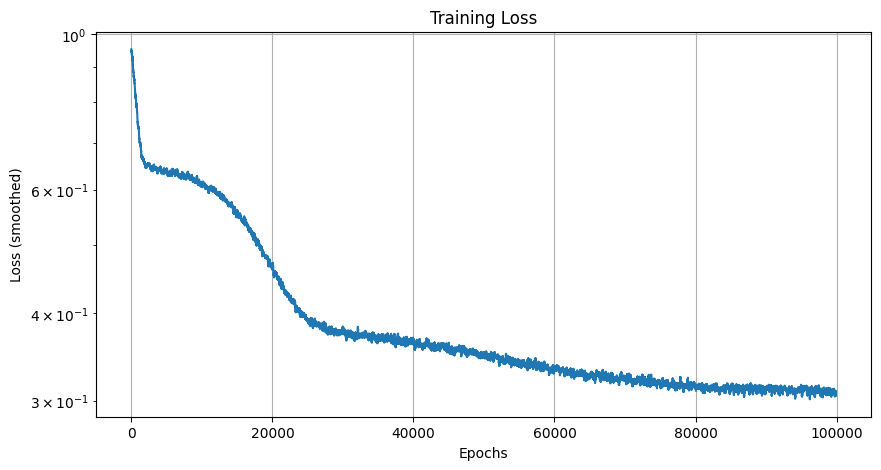

In [12]:
class SimpleScoreNetwork(nn.Module):
    """Simple MLP for score prediction without fancy embeddings"""
    def __init__(self, hidden_dim=128):
        super().__init__()
        
        # Simple MLP architecture
        self.net = nn.Sequential(
            # First layer takes input x and time t (2 input features)
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # Output the score
        )
    
    def forward(self, x, t):
        x_t = torch.cat([x, t], dim=1)
        return self.net(x_t)

def train_score_network(n_epochs=10000, batch_size=1024, lr=1e-5):
    # Initialize model and optimizer - using the simple network
    score_net = SimpleScoreNetwork(hidden_dim=128)
    optimizer = optim.Adam(score_net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, verbose=True)
    
    # For tracking progress
    losses = []
    
    # Following the tutorial approach
    optimizer.zero_grad()  # Initialize gradients once at the beginning
    accumulation_steps = 8
    
    for epoch in tqdm(range(n_epochs), desc="Training Score Network"):
        # Sample x_0 from the mixture of Gaussians
        x0 = sample_x0(batch_size)
        
        # Sample t uniformly between 0.001 and 0.999 to avoid edge cases
        t = torch.rand(batch_size, 1) * 0.998 + 0.001
        
        # Sample x_t and get the noise used
        xt, epsilon = sample_xt_given_x0(x0, t)

        # Compute the predicted score
        pred_score = score_net(xt, t)

        # Get standard deviation for the time step
        std = torch.sqrt(conditional_var(t))

        # The tutorial's unified loss (L_simple)
        loss = F.mse_loss(std * pred_score + epsilon, torch.zeros_like(epsilon)) / accumulation_steps
        
        loss.backward()
        
        # Store the original (non-divided) loss for monitoring
        losses.append(loss.item() * accumulation_steps)
        
        # Update weights after accumulation steps
        if (epoch + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        # Learning rate scheduling
        if epoch % 100 == 0:
            avg_loss = np.mean(losses[-100:]) if len(losses) >= 100 else np.mean(losses)
            scheduler.step(avg_loss)
    
    # Plot training loss at the end of training
    plt.figure(figsize=(10, 5))
    window_size = min(100, len(losses))
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    plt.plot(smoothed_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (smoothed)')
    plt.title('Training Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('training_loss.png')
    
    return score_net

# Train the network
score_net = train_score_network(n_epochs=100000)

# Save the model
torch.save(score_net.state_dict(), 'score_net.pt')

# Part 1.3

## Euler's Method for SDEs - Mathematical Foundation

### General Euler Discretization

For any SDE of the form:
$$dx_t = \mu(x_t, t)dt + \sigma(x_t, t)dw_t$$

The **Euler discretization** is:
$$x(t + \varepsilon) \approx x_t + \varepsilon\mu(x_t, t) + \sigma(x_t, t)\sqrt{\varepsilon}z_t$$

where:
- $z_t \sim \mathcal{N}(0,1)$ (standard normal random variable)
- $\sqrt{\varepsilon}z_t \sim \mathcal{N}(0,\varepsilon)$ (properly scaled noise)
- $\varepsilon$ is the discrete time step size

### Applying to Variance Preserving SDE

For our specific VP SDE:
$$dx_t = -\frac{1}{2}\beta(t)x_t dt + \sqrt{\beta(t)} dw_t$$

We identify the coefficients:
- **Drift coefficient**: $\mu(x_t, t) = -\frac{1}{2}\beta(t)x_t$
- **Diffusion coefficient**: $\sigma(x_t, t) = \sqrt{\beta(t)}$

### Euler Update Formula

Substituting into the general Euler discretization:
$$x(t + \varepsilon) = x_t + \varepsilon \left(-\frac{1}{2}\beta(t)x_t\right) + \sqrt{\beta(t)} \cdot \sqrt{\varepsilon} \cdot z_t$$

Simplifying:
$$x(t + \varepsilon) = x_t - \frac{1}{2}\beta(t)x_t\varepsilon + \sqrt{\beta(t)\varepsilon} \cdot z_t$$

### Decomposition of the Update

The Euler step consists of two parts:

1. **Drift term** (deterministic): $-\frac{1}{2}\beta(t)x_t\varepsilon$
   - Represents the systematic change in $x_t$
   - Causes exponential decay toward zero

2. **Diffusion term** (stochastic): $\sqrt{\beta(t)\varepsilon} \cdot z_t$
   - Represents random fluctuations
   - Maintains proper variance structure

### Critical Scaling Property

The key insight is the **$\sqrt{\varepsilon}$ scaling** of the noise term:
- Standard Brownian motion increments satisfy: $w(t + \varepsilon) - w(t) \sim \mathcal{N}(0, \varepsilon)$
- This gives variance that scales linearly with time step size
- Essential for preserving the statistical properties of the continuous SDE

### Convergence Guarantee

For sufficiently small $\varepsilon$, samples from the discrete Euler process converge to samples from the continuous SDE solution. Specifically:

$$\lim_{\varepsilon \to 0} \text{Euler}(x_0, T, \varepsilon) \xrightarrow{d} \text{SDE}(x_0, T)$$

where $\xrightarrow{d}$ denotes convergence in distribution.

### Why We Expect $\mathcal{N}(0,1)$

With $\beta(t) = 0.1 + 19.9t$ over $t \in [0,1]$:

$$\int_0^1 \beta(s)ds = 10.05$$

The VP SDE theory guarantees:
- **Mean decay**: $\mu_1 = \mu_0 \cdot e^{-5.025} \approx 0$
- **Variance preservation**: $\Sigma_1 = I$ (unit variance maintained)

Therefore: $x_1 \sim \mathcal{N}(0, 1)$ regardless of initial distribution complexity.

Final distribution - Mean: -0.0037, Variance: 1.0031


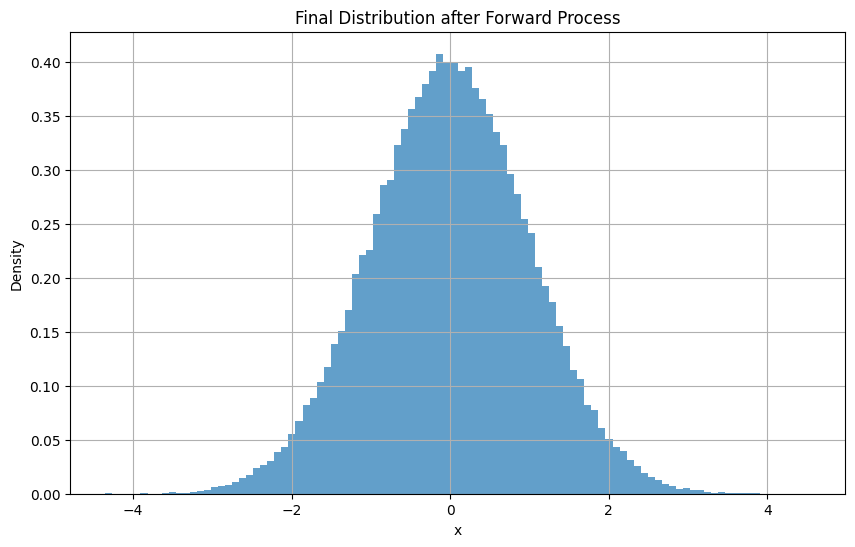

In [13]:
def euler_forward_process(x_0, T=1000, dt=1e-2):
    """
    Advance x_0 according to the VP SDE using Euler's method
    
    Args:
        x_0: Initial points [batch_size, 1]
        T: Number of steps
        dt: Step size
    
    Returns:
        x_T: Final points after T steps
    """
    x_t = x_0.clone()
    dt = 1.0 / T  # This is our ε (step size)
    
    for step in range(T):
        t = torch.tensor(step * dt)
        beta_t = BETA_0 + (BETA_1 - BETA_0) * t
        drift = -0.5 * beta_t * x_t * dt        
        diffusion = torch.sqrt(beta_t * dt) * torch.randn_like(x_t)
        x_t = x_t + drift + diffusion
    
    return x_t

num_samples = 100000
x_0 = sample_x0(num_samples)
x_T = euler_forward_process(x_0, T=1000)

plt.figure(figsize=(10, 6))
plt.hist(x_T.numpy(), bins=100, density=True, alpha=0.7)
plt.title('Final Distribution after Forward Process')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.savefig('forward_process_final_dist.png')
mean = x_T.mean().item()
var = x_T.var().item()
print(f"Final distribution - Mean: {mean:.4f}, Variance: {var:.4f}")

# Part 1.4

### Probability Flow ODE Derivation

The reverse SDE is:
$$dx_\tau = \left(\mu(x_\tau, \tau) - \sigma^2(\tau)\nabla_{x_\tau} \log p_\tau(x_\tau)\right) d\tau + \sigma(\tau) d\tilde{w}_\tau$$

The **probability flow ODE** removes the stochastic term and modifies the drift:
$$dx_\tau = \left[\mu(x_\tau, \tau) - \frac{1}{2}\sigma^2(\tau)\nabla_{x_\tau} \log p_\tau(x_\tau)\right] d\tau$$

### For VP SDE Forward Process

For the VP SDE:
- $\mu(x, t) = -\frac{1}{2}\beta(t)x$
- $\sigma^2(t) = \beta(t)$

The probability flow ODE becomes:
$$dx = \left[-\frac{1}{2}\beta(t)x - \frac{1}{2}\beta(t)\nabla_x \log p_t(x)\right] dt$$

### Key Insight

The probability flow ODE preserves the **same marginal distributions** $p_t(x)$ as the original SDE, but follows **deterministic trajectories** instead of stochastic ones.

Probability Flow ODE Forward: 100%|██████████| 1000/1000 [00:05<00:00, 196.10it/s]


Probability Flow ODE - Mean: -0.0352, Variance: 0.9372
Regular SDE - Mean: -0.0100, Variance: 0.9418
Expected: Mean ≈ 0, Variance ≈ 1


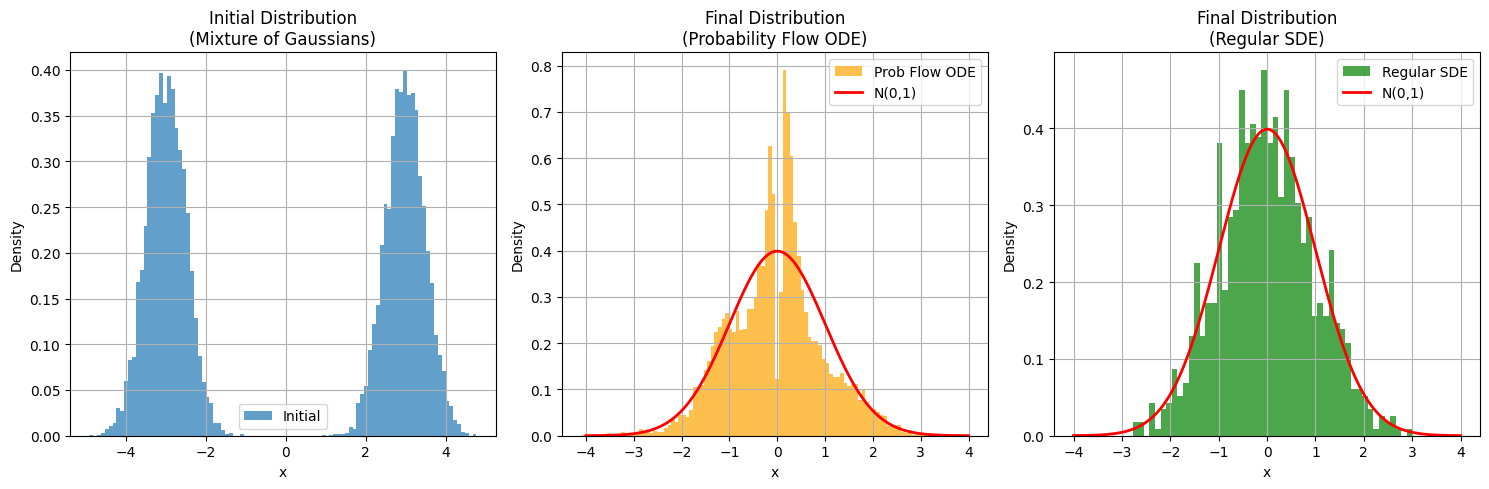

In [14]:
def probability_flow_ode_forward(x_0, score_model, T=1000):
    """
    Advance points according to the probability flow ODE (forward process)
    
    For VP SDE, the probability flow ODE is:
    dx = [-0.5*beta_t*x - 0.5*beta_t*score_model(x,t)] dt
    
    Args:
        x_0: Initial points [batch_size, 1]
        score_model: Trained score model
        T: Number of steps
    
    Returns:
        x_T: Final points after T steps
    """
    x_t = x_0.clone()
    dt = 1.0 / T  # Consistent time stepping
    
    # Set model to evaluation mode
    score_model.eval()
    
    with torch.no_grad():
        for step in tqdm(range(T), desc="Probability Flow ODE Forward"):
            t = torch.tensor(step * dt)
            beta_t = BETA_0 + (BETA_1 - BETA_0) * t
            
            # Create time tensor for score model
            t_tensor = torch.ones_like(x_t) * t
            score_estimate = score_model(x_t, t_tensor)
            
            # Probability flow ODE update (forward process)
            # dx = [-0.5*beta_t*x - 0.5*beta_t*score(x,t)] dt
            drift_regular = -0.5 * beta_t * x_t * dt
            drift_score = -0.5 * beta_t * score_estimate * dt  # Fixed: added -0.5*beta_t factor
            
            # Update x_t (deterministic ODE, no noise term)
            x_t = x_t + drift_regular + drift_score
    
    return x_t

# Load the trained score model
score_net = SimpleScoreNetwork(hidden_dim=128)
score_net.load_state_dict(torch.load('score_net.pt'))

# Sample 10,000 random starting points
num_samples = 10000
x_0 = sample_x0(num_samples)

x_T_flow = probability_flow_ode_forward(x_0, score_net, T=1000)
x_T_sde = euler_forward_process(x_0[:1000], T=1000)  

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(x_0.numpy(), bins=100, density=True, alpha=0.7, label='Initial')
plt.title('Initial Distribution\n(Mixture of Gaussians)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.hist(x_T_flow.numpy(), bins=100, density=True, alpha=0.7, label='Prob Flow ODE', color='orange')
x_range = torch.linspace(-4, 4, 1000)
theoretical = torch.exp(-0.5 * x_range**2) / torch.sqrt(2 * torch.tensor(torch.pi))
plt.plot(x_range.numpy(), theoretical.numpy(), 'r-', linewidth=2, label='N(0,1)')
plt.title('Final Distribution\n(Probability Flow ODE)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(x_T_sde.numpy(), bins=50, density=True, alpha=0.7, label='Regular SDE', color='green')
plt.plot(x_range.numpy(), theoretical.numpy(), 'r-', linewidth=2, label='N(0,1)')
plt.title('Final Distribution\n(Regular SDE)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('probability_flow_vs_sde_comparison.png', dpi=150)

mean_flow = x_T_flow.mean().item()
var_flow = x_T_flow.var().item()
mean_sde = x_T_sde.mean().item()
var_sde = x_T_sde.var().item()

print(f"Probability Flow ODE - Mean: {mean_flow:.4f}, Variance: {var_flow:.4f}")
print(f"Regular SDE - Mean: {mean_sde:.4f}, Variance: {var_sde:.4f}")
print("Expected: Mean ≈ 0, Variance ≈ 1")

# Part 1.5

## Reverse SDE Mathematical Implementation

### 1. Anderson's Reverse SDE 

**For VP SDE Forward Process**:
$$dx = -\frac{1}{2}\beta(t)x dt + \sqrt{\beta(t)} dw$$

**Anderson's Reverse SDE**:
$$dx = \left[-\frac{1}{2}\beta(t)x - \beta(t)\nabla_x \log p_t(x)\right]dt + \sqrt{\beta(t)}d\bar{w}$$

### 2. Implementation: Time Reversal

**Code Logic**: To sample from $t=1 \to t=0$, we parameterize:
- Time: `t_val = 1.0 - (step + 1) * dt_val`
- Steps: `step = 0, 1, ..., T-1`
- Result: $t = 1, 0.999, 0.998, ..., 0.001$

### 3. Euler-Maruyama Discretization (From Tutorial)

**Reverse SDE Euler Update**:
$$x_{i-1} = x_i + \left[\frac{1}{2}\beta(t_i)x_i + \beta(t_i)s_\theta(x_i, t_i)\right]\Delta t + \sqrt{\beta(t_i)\Delta t} \, z_i$$

**Code Implementation**:
```python
# Reverse drift: +1/2 β(t) x (opposite of forward)
drift = 0.5 * beta_t * x_t * dt

# Score correction: β(t) * score_model(x,t)  
score_drift = beta_t * score_estimate * dt

# Noise: √(β(t) * dt) * N(0,1)
diffusion = torch.sqrt(beta_t * dt) * torch.randn_like(x_t)

# Combined update
x_t = x_t + drift + score_drift + diffusion

Tracking samples at indices: [542, 67]


Reverse SDE Sampling:  39%|███▊      | 386/1000 [00:02<00:03, 180.75it/s]

Reverse SDE Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 187.99it/s]


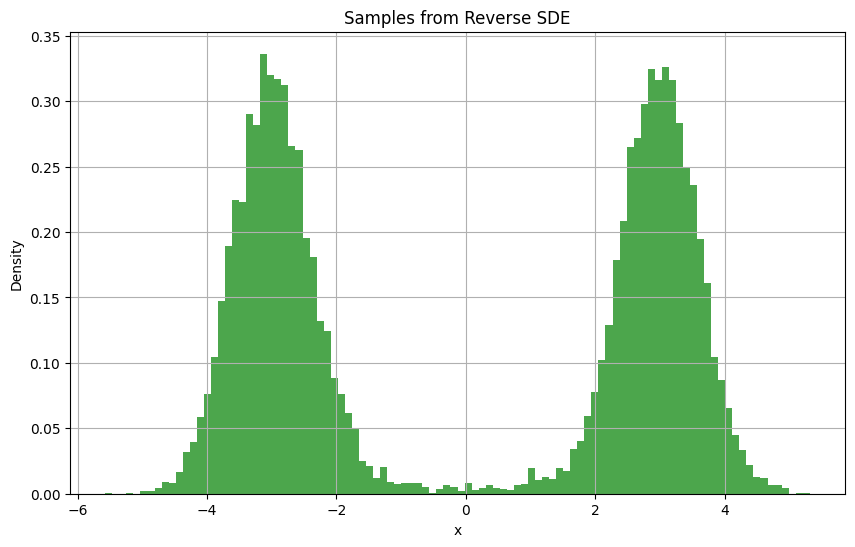

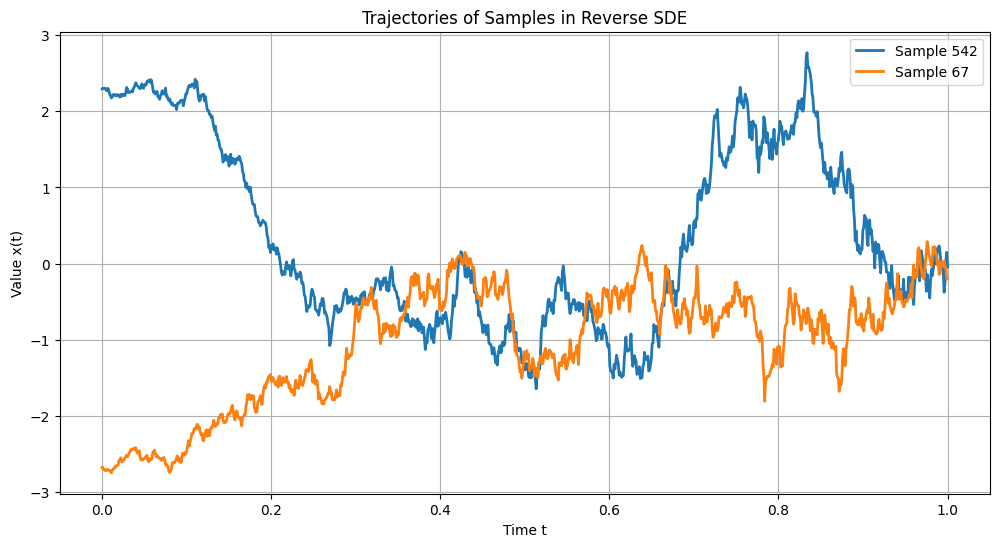

Generated distribution - Mean: 0.0118, Variance: 9.1748

=== MODE RECOVERY ANALYSIS ===
Proportion near -3: 0.4372
Proportion near +3: 0.4446
Proportion near center: 0.0110
Expected: ~0.5 near each mode, ~0 in center

Reverse SDE analysis complete


In [15]:
def reverse_sde_sampling(score_model, num_samples=10000, T=1000, track_indices=None):
    """
    Sample from the reverse SDE using Euler-Maruyama discretization.
    """
    score_model.eval()
    
    # Start from the prior distribution (standard normal)
    x_t = torch.randn(num_samples, 1)
    
    trajectories = {}
    if track_indices is not None:
        for idx in track_indices:
            trajectories[idx] = [x_t[idx].item()]
    
    dt_val = 1.0 / T
    
    with torch.no_grad():
        for step in tqdm(range(T), desc="Reverse SDE Sampling"):
            t_val = 1.0 - (step + 1) * dt_val
            
            if t_val <= 0.001:
                continue
                
            t = torch.tensor(t_val)
            dt = torch.tensor(dt_val)
            beta_t = BETA_0 + (BETA_1 - BETA_0) * t            
            t_tensor = torch.ones_like(x_t) * t            
            score_estimate = score_model(x_t, t_tensor)            
            score_estimate = torch.clamp(score_estimate, -10, 10)
            
            drift = 0.5 * beta_t * x_t * dt
            score_drift = beta_t * score_estimate * dt
            
            diffusion_coeff = torch.sqrt(beta_t * dt)
            diffusion = diffusion_coeff * torch.randn_like(x_t)
            
            x_t = x_t + drift + score_drift + diffusion
            
            if track_indices is not None:
                for idx in track_indices:
                    trajectories[idx].append(x_t[idx].item())
    
    return x_t, trajectories

torch.manual_seed(42)
track_indices = torch.randint(0, 1000, (2,)).tolist()
print(f"Tracking samples at indices: {track_indices}")

x_0_samples, trajectories = reverse_sde_sampling(
    score_net,
    num_samples=10000,
    T=1000,
    track_indices=track_indices
)

plt.figure(figsize=(10, 6))
plt.hist(x_0_samples.numpy(), bins=100, density=True, alpha=0.7, color='green')
plt.title('Samples from Reverse SDE')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.savefig('reverse_sde_samples.png')
plt.show()

plt.figure(figsize=(12, 6))
time_points_sde = len(trajectories[list(trajectories.keys())[0]])
times_sde = np.linspace(1.0, 0, time_points_sde) # Time goes backward from 1 to 0

for idx, values in trajectories.items():
    plt.plot(times_sde, values, label=f'Sample {idx}', linewidth=2)
plt.title('Trajectories of Samples in Reverse SDE')
plt.xlabel('Time t')
plt.ylabel('Value x(t)')
plt.legend()
plt.grid(True)
plt.savefig('reverse_sde_trajectories.png')
plt.show()

mean_0 = x_0_samples.mean().item()
var_0 = x_0_samples.var().item()
print(f"Generated distribution - Mean: {mean_0:.4f}, Variance: {var_0:.4f}")

near_minus3 = ((x_0_samples < -2) & (x_0_samples > -4)).sum().item() / len(x_0_samples)
near_plus3 = ((x_0_samples < 4) & (x_0_samples > 2)).sum().item() / len(x_0_samples)
near_center = ((x_0_samples < 1) & (x_0_samples > -1)).sum().item() / len(x_0_samples)

print(f"\n=== MODE RECOVERY ANALYSIS ===")
print(f"Proportion near -3: {near_minus3:.4f}")
print(f"Proportion near +3: {near_plus3:.4f}")
print(f"Proportion near center: {near_center:.4f}")
print(f"Expected: ~0.5 near each mode, ~0 in center")
print("\nReverse SDE analysis complete")

# Part 1.6 (bonus)

## Reverse Probability Flow ODE Implementation

### 1. Probability Flow Theory (From Tutorial Slides)

There exists a **deterministic ODE** that preserves the same marginal distributions as the SDE:

**General Probability Flow ODE**:
$$dx_\tau = \left[\mu(x_\tau, \tau) - \frac{1}{2}\sigma^2(\tau)\nabla_{x_\tau} \log p_\tau(x_\tau)\right]d\tau$$

**Key Difference from SDE**: No stochastic term `+ σ(τ)dw̄`

### 2. VP SDE Probability Flow (From Tutorial)

**For VP SDE**: $f(x,t) = -\frac{1}{2}\beta(t)x$, $g^2(t) = \beta(t)$

**Reverse Probability Flow ODE**:
$$dx = \left[-\frac{1}{2}\beta(t)x - \frac{1}{2}\beta(t)\nabla_x \log p_t(x)\right]dt$$

**Implementation** (time reversal from $t=1 \to t=0$):
$$dx = \left[\frac{1}{2}\beta(t)x + \frac{1}{2}\beta(t)s_\theta(x,t)\right]dt$$


Tracking samples at indices: [0, 1]


Reverse Probability Flow ODE: 100%|██████████| 1000/1000 [00:05<00:00, 196.50it/s]


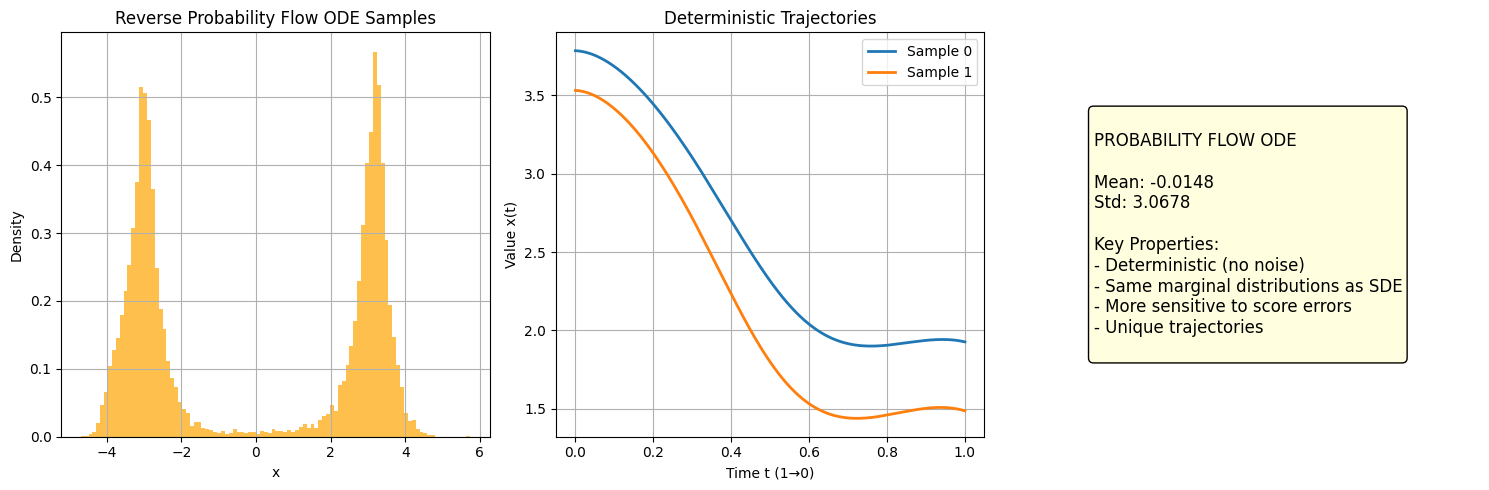

ODE Results - Mean: -0.0148, Std: 3.0678


In [16]:
def reverse_probability_flow_ode(score_model, num_samples=10000, T=1000, track_indices=None):
    """
    Sample from reverse probability flow ODE (deterministic)
    """
    score_model.eval()
    
    x_t = torch.randn(num_samples, 1)
    
    trajectories = {}
    if track_indices is not None:
        for idx in track_indices:
            trajectories[idx] = [x_t[idx].item()]
    
    dt_val = 1.0 / T
    
    with torch.no_grad():
        for step in tqdm(range(T), desc="Reverse Probability Flow ODE"):
            t_val = 1.0 - (step + 1) * dt_val
            
            if t_val <= 0.001:
                continue
                
            t = torch.tensor(t_val)
            dt = torch.tensor(dt_val)
            beta_t = BETA_0 + (BETA_1 - BETA_0) * t
            
            t_tensor = torch.ones_like(x_t) * t
            score_estimate = score_model(x_t, t_tensor)
            score_estimate = torch.clamp(score_estimate, -10, 10)
            
            drift = 0.5 * beta_t * x_t * dt
            score_drift = 0.5 * beta_t * score_estimate * dt  
            
            x_t = x_t + drift + score_drift
            
            if track_indices is not None:
                for idx in track_indices:
                    trajectories[idx].append(x_t[idx].item())
    
    return x_t, trajectories

torch.manual_seed(42)
track_indices = [0, 1]  
print(f"Tracking samples at indices: {track_indices}")

x_0_ode_samples, ode_trajectories = reverse_probability_flow_ode(
    score_net,
    num_samples=10000,
    T=1000,
    track_indices=track_indices
)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(x_0_ode_samples.numpy(), bins=100, density=True, alpha=0.7, color='orange')
plt.title('Reverse Probability Flow ODE Samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)

plt.subplot(1, 3, 2)
time_points = len(ode_trajectories[track_indices[0]])
times = np.linspace(1.0, 0, time_points)

for idx, values in ode_trajectories.items():
    plt.plot(times, values, label=f'Sample {idx}', linewidth=2)
plt.title('Deterministic Trajectories')
plt.xlabel('Time t (1→0)')
plt.ylabel('Value x(t)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.axis('off')
mean_ode = x_0_ode_samples.mean().item()
std_ode = x_0_ode_samples.std().item()

stats_text = f"""
PROBABILITY FLOW ODE

Mean: {mean_ode:.4f}
Std: {std_ode:.4f}

Key Properties:
- Deterministic (no noise)
- Same marginal distributions as SDE
- More sensitive to score errors
- Unique trajectories
"""
plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle="round", facecolor="lightyellow"))

plt.tight_layout()
plt.savefig('reverse_probability_flow_ode.png', dpi=150)
plt.show()

print(f"ODE Results - Mean: {mean_ode:.4f}, Std: {std_ode:.4f}")

# Part 1.B

Display the histogram of $\mathbf{x}_t$ as a function of time using a heatmap on the $y$ axis. You can use meshgrids and `matplotlib`'s pcolormesh to display the histogram as shown below. There should be 3/4 total histograms:

1. Histogram of Euler discretization of forward SDE (100,000 starting points).
2. Histogram of Euler discretization of probability flow ODE (10,000 starting points). It's ok if the histogram isn't as nice as the SDE histogram, but points will still be deducted if it's very different in general behavior.
3. Histogram of Euler discretization of reverse SDE (10,000 starting points). It's ok if it isn't exactly the reverse of the forward SDE, but points will still be removed if there are mistakes in the code.
4. (Bonus) Histogram of Euler discretization of reverse probability flow ODE (10,000 starting points).

## Part 1.B.1 

Generating clean forward SDE evolution...


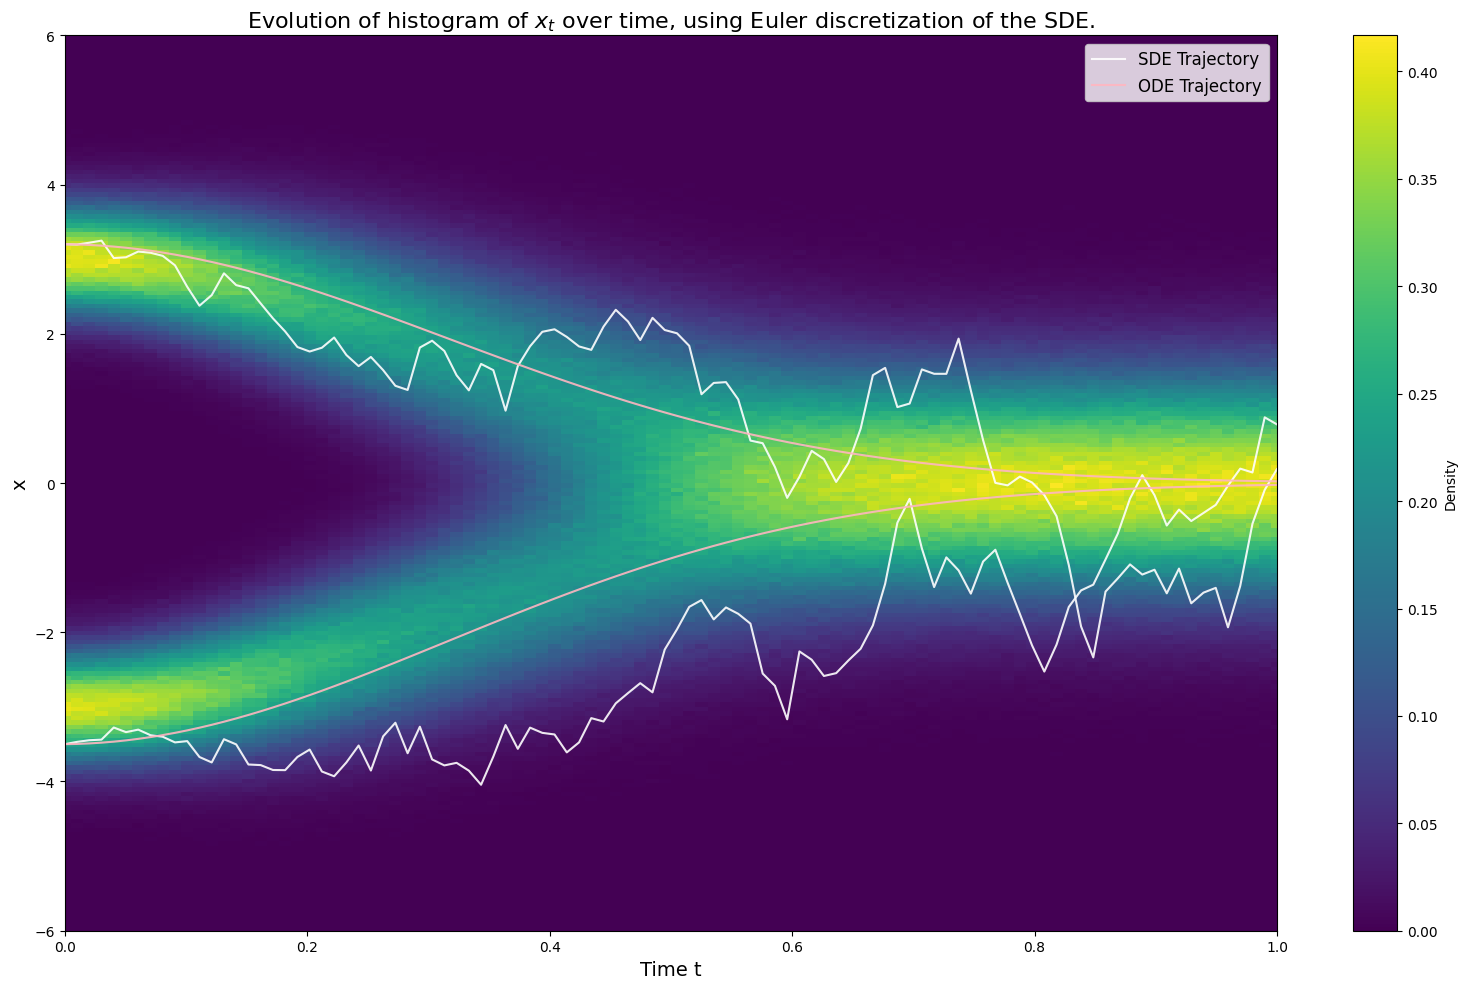

Clean forward SDE evolution complete!
- Shows transition from bimodal (bright spots at ±3) to unimodal (bright band at 0)
- 2 white jagged lines: SDE trajectories (stochastic)
- 2 pink smooth lines: ODE trajectories (deterministic)


In [17]:
def create_clean_forward_evolution():
    num_samples_heatmap = 100000  # For density estimation
    num_trajectories = 2         # Just 2 trajectories of each type
    T = 1000
    time_snapshots = 100
    
    print("Generating clean forward SDE evolution...")
    
    x_0_heatmap = sample_x0(num_samples_heatmap)
    
    # Manually select good starting points for trajectories to show the effect clearly
    x_0_trajectories = torch.tensor([[-3.5], [3.2]])  
    
    dt = 1.0 / T
    snapshot_interval = T // time_snapshots
    times = np.linspace(0, 1, time_snapshots)
    x_range = (-6, 6)
    bins = 200
    x_edges = np.linspace(x_range[0], x_range[1], bins + 1)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    
    heatmap_data = np.zeros((bins, time_snapshots))
    sde_trajectories = np.zeros((num_trajectories, time_snapshots))
    ode_trajectories = np.zeros((num_trajectories, time_snapshots))
    
    x_t_heatmap = x_0_heatmap.clone()
    x_t_sde = x_0_trajectories.clone()
    x_t_ode = x_0_trajectories.clone()  # Same starting points
    
    hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
    heatmap_data[:, 0] = hist
    sde_trajectories[:, 0] = x_t_sde.numpy().flatten()
    ode_trajectories[:, 0] = x_t_ode.numpy().flatten()
    
    snapshot_idx = 1
    
    # Run forward evolution
    for step in range(T):
        t = torch.tensor(step * dt)
        beta_t = BETA_0 + (BETA_1 - BETA_0) * t
        
        drift_heatmap = -0.5 * beta_t * x_t_heatmap * dt
        diffusion_heatmap = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_heatmap)
        x_t_heatmap = x_t_heatmap + drift_heatmap + diffusion_heatmap
        
        drift_sde = -0.5 * beta_t * x_t_sde * dt
        diffusion_sde = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_sde)
        x_t_sde = x_t_sde + drift_sde + diffusion_sde
        
        drift_ode = -0.5 * beta_t * x_t_ode * dt
        x_t_ode = x_t_ode + drift_ode
        
        if (step + 1) % snapshot_interval == 0 and snapshot_idx < time_snapshots:
            hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
            heatmap_data[:, snapshot_idx] = hist
            sde_trajectories[:, snapshot_idx] = x_t_sde.numpy().flatten()
            ode_trajectories[:, snapshot_idx] = x_t_ode.numpy().flatten()
            snapshot_idx += 1
    
    return times, x_centers, heatmap_data, sde_trajectories, ode_trajectories

plt.figure(figsize=(16, 10))

times, x_centers, heatmap_data, sde_trajectories, ode_trajectories = create_clean_forward_evolution()

T_grid, X_grid = np.meshgrid(times, x_centers)
plt.pcolormesh(T_grid, X_grid, heatmap_data, shading='auto', cmap='viridis', alpha=1.0)
plt.colorbar(label='Density')

# Overlay just 2 SDE trajectories (white, jagged lines)
for i in range(sde_trajectories.shape[0]):
    plt.plot(times, sde_trajectories[i, :], 'white', linewidth=1.5, alpha=0.9, 
             label='SDE Trajectory' if i == 0 else "")

# Overlay just 2 ODE trajectories (light pink, smooth lines)  
for i in range(ode_trajectories.shape[0]):
    plt.plot(times, ode_trajectories[i, :], 'lightpink', linewidth=1.5, alpha=0.9,
             label='ODE Trajectory' if i == 0 else "")

plt.xlabel('Time t', fontsize=14)
plt.ylabel('x', fontsize=14)
plt.title('Evolution of histogram of $x_t$ over time, using Euler discretization of the SDE.', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(False)  # Remove grid for cleaner look

plt.xlim(0, 1)
plt.ylim(-6, 6)

plt.tight_layout()
plt.savefig('forward_sde_evolution_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("Clean forward SDE evolution complete!")
print("- Shows transition from bimodal (bright spots at ±3) to unimodal (bright band at 0)")
print("- 2 white jagged lines: SDE trajectories (stochastic)")  
print("- 2 pink smooth lines: ODE trajectories (deterministic)")

1. Running Forward SDE...


2. Running Forward ODE...
3. Running Reverse SDE...
4. Running Reverse ODE...


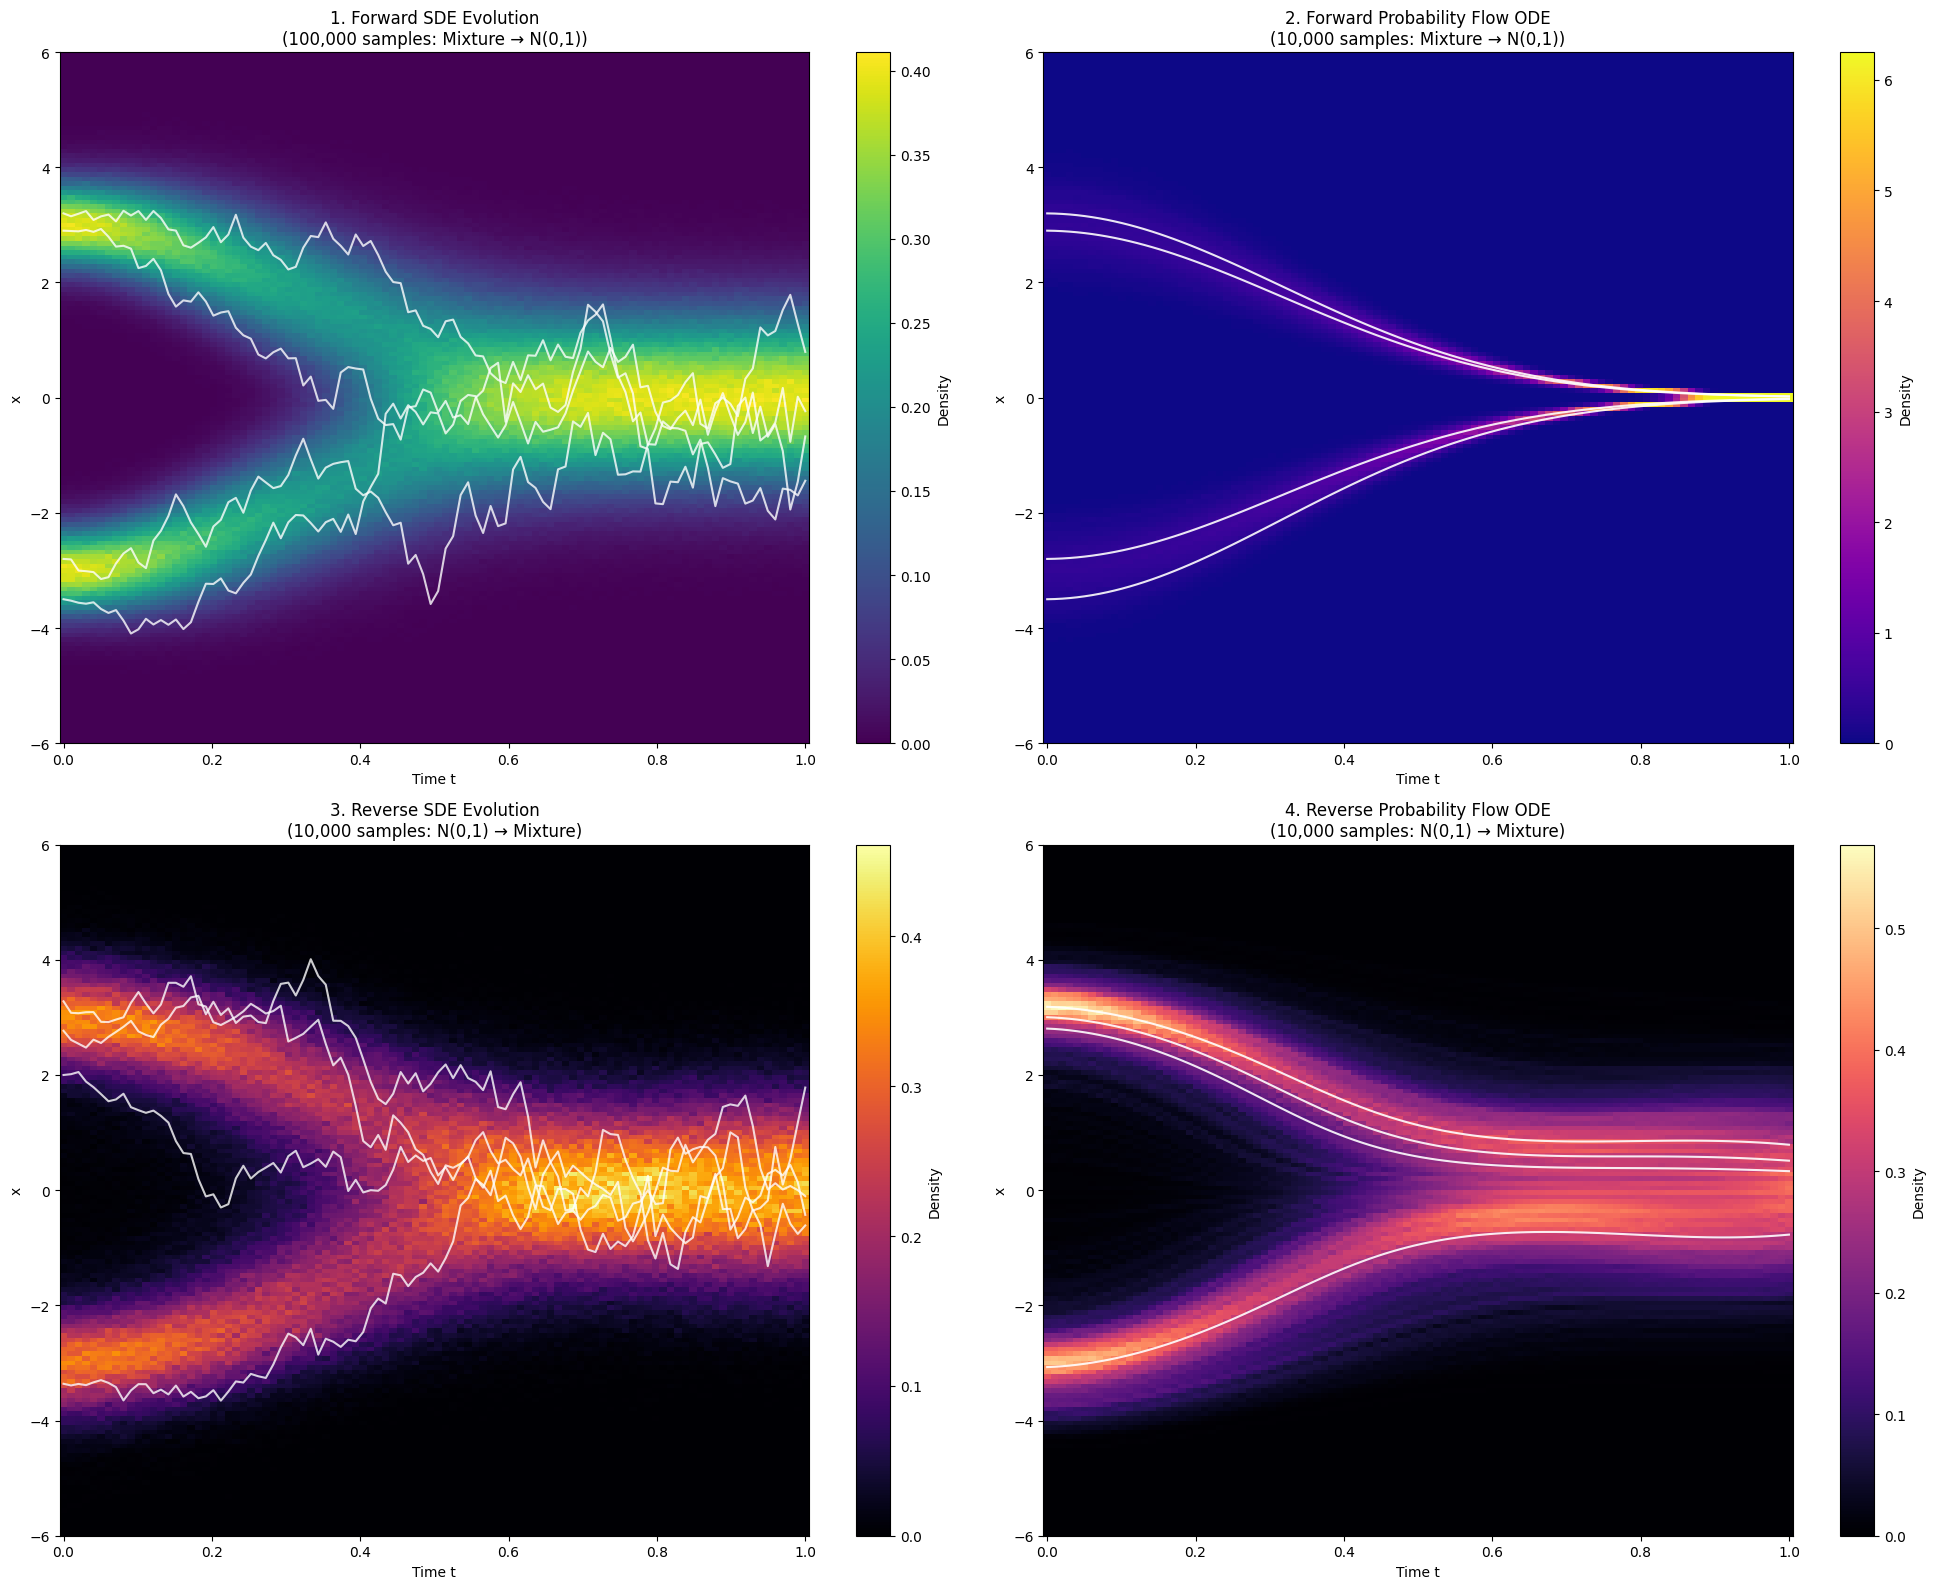

Clean 4-panel evolution heatmaps complete!


In [ ]:
def create_all_four_evolution_heatmaps_clean():
    """
    Create 4 separate heatmaps with just a few trajectory overlays
    """
    
    # Common parameters
    T = 1000
    time_snapshots = 100
    x_range = (-6, 6)
    bins = 150
    x_edges = np.linspace(x_range[0], x_range[1], bins + 1)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    dt = 1.0 / T
    snapshot_interval = T // time_snapshots
    num_trajectories = 4  # Much fewer trajectories - like in your example
    
    def run_forward_sde(num_samples):
       """
        Simulate forward SDE evolution: dx = -0.5*β(t)*x*dt + √β(t)*dw
        
        Args:
            num_samples (int): Number of samples for density estimation
        
        Returns:
            tuple: (times, heatmap_data, trajectories)
                - times: Time points from 0 to 1
                - heatmap_data: Density evolution [bins x time_snapshots]
                - trajectories: Sample trajectories [num_trajectories x time_snapshots]
        
        Implementation:
            - Uses VP SDE with β(t) = β₀ + (β₁-β₀)*t
            - Tracks both population density and individual trajectories
            - Applies Euler-Maruyama discretization
        """
        times = np.linspace(0, 1, time_snapshots)
        heatmap_data = np.zeros((bins, time_snapshots))
        
        # Heatmap samples
        x_t_heatmap = sample_x0(num_samples)
        # Trajectory samples - manually select good starting points
        x_t_traj = torch.tensor([[-3.5], [3.2], [-2.8], [2.9]])  # 4 trajectories
        trajectories = np.zeros((num_trajectories, time_snapshots))
        
        # Initial state
        hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
        heatmap_data[:, 0] = hist
        trajectories[:, 0] = x_t_traj.numpy().flatten()
        
        snapshot_idx = 1
        for step in range(T):
            t = torch.tensor(step * dt)
            beta_t = BETA_0 + (BETA_1 - BETA_0) * t
            
            # Update heatmap
            drift_h = -0.5 * beta_t * x_t_heatmap * dt
            diffusion_h = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_heatmap)
            x_t_heatmap = x_t_heatmap + drift_h + diffusion_h
            
            # Update trajectories
            drift_t = -0.5 * beta_t * x_t_traj * dt
            diffusion_t = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_traj)
            x_t_traj = x_t_traj + drift_t + diffusion_t
            
            if (step + 1) % snapshot_interval == 0 and snapshot_idx < time_snapshots:
                hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
                heatmap_data[:, snapshot_idx] = hist
                trajectories[:, snapshot_idx] = x_t_traj.numpy().flatten()
                snapshot_idx += 1
        
        return times, heatmap_data, trajectories
    
    def run_forward_ode(num_samples):
        """
            Simulate forward Probability Flow ODE evolution from mixture to Gaussian.
            
            Implements the deterministic ODE: dx = -0.5*β(t)*x*dt
            This is the probability flow ODE corresponding to the VP SDE, which produces
            the same marginal distributions as the SDE but with deterministic trajectories.
            
            Args:
                num_samples (int): Number of samples for density estimation heatmap
            
            Returns:
                tuple: (times, heatmap_data, trajectories)
                    - times (np.array): Time points from 0 to 1 [time_snapshots]
                    - heatmap_data (np.array): Density evolution [bins x time_snapshots] 
                    - trajectories (np.array): Deterministic path traces [4 x time_snapshots]
            
            Mathematical Background:
                - Probability flow ODE has same marginal p_t(x) as corresponding SDE
                - Pure drift equation (no stochastic term) gives smooth trajectories
                - Drift coefficient -0.5*β(t)*x causes exponential decay toward zero
                - Solution: x(t) = x(0) * exp(-0.5 * ∫₀ᵗ β(s)ds)
            
            Implementation Details:
                - Uses forward Euler discretization with dt = 1/T
                - No noise term (deterministic evolution)
                - Same β(t) schedule as VP SDE for fair comparison
                - Trajectories are smooth curves unlike jagged SDE paths
                - Final distribution matches SDE result but paths are deterministic
            
            """
        times = np.linspace(0, 1, time_snapshots)
        heatmap_data = np.zeros((bins, time_snapshots))
        
        x_t_heatmap = sample_x0(num_samples)
        x_t_traj = torch.tensor([[-3.5], [3.2], [-2.8], [2.9]])  # Same starting points
        trajectories = np.zeros((num_trajectories, time_snapshots))
        
        hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
        heatmap_data[:, 0] = hist
        trajectories[:, 0] = x_t_traj.numpy().flatten()
        
        snapshot_idx = 1
        for step in range(T):
            t = torch.tensor(step * dt)
            beta_t = BETA_0 + (BETA_1 - BETA_0) * t
            
            # Only drift for ODE
            drift_h = -0.5 * beta_t * x_t_heatmap * dt
            x_t_heatmap = x_t_heatmap + drift_h
            
            drift_t = -0.5 * beta_t * x_t_traj * dt
            x_t_traj = x_t_traj + drift_t
            
            if (step + 1) % snapshot_interval == 0 and snapshot_idx < time_snapshots:
                hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
                heatmap_data[:, snapshot_idx] = hist
                trajectories[:, snapshot_idx] = x_t_traj.numpy().flatten()
                snapshot_idx += 1
        
        return times, heatmap_data, trajectories
    
    def run_reverse_sde(num_samples):
            """
            Simulate reverse-time SDE sampling from Gaussian to mixture distribution.
            
            Implements: dx = [0.5*β(t)*x + β(t)*score(x,t)]*dt + √β(t)*dw̃
            Uses trained score network to estimate ∇log p_t(x) for reverse evolution.
            
            Args:
                num_samples (int): Number of samples for density estimation
            
            Returns:
                tuple: (times, heatmap_data, trajectories) 
                    - times: Backward time from 1→0
                    - heatmap_data: Density evolution [bins x snapshots]
                    - trajectories: 4 stochastic sample paths
            
            Implementation:
                - Starts from N(0,1) noise, evolves backward in time
                - Uses trained score_net for ∇log p_t(x) estimation
                - Applies Euler-Maruyama with reverse drift and diffusion
                - Score clamping [-10,10] for numerical stability
                - Generates samples from learned data distribution
            """
        times = np.linspace(1, 0, time_snapshots)
        heatmap_data = np.zeros((bins, time_snapshots))
        
        x_t_heatmap = torch.randn(num_samples, 1)
        x_t_traj = torch.randn(num_trajectories, 1)  # Random starting points from N(0,1)
        trajectories = np.zeros((num_trajectories, time_snapshots))
        
        hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
        heatmap_data[:, 0] = hist
        trajectories[:, 0] = x_t_traj.numpy().flatten()
        
        snapshot_idx = 1
        score_net.eval()
        
        with torch.no_grad():
            for step in range(T):
                t_val = 1.0 - (step + 1) * dt
                if t_val <= 0.001:
                    continue
                    
                t = torch.tensor(t_val)
                beta_t = BETA_0 + (BETA_1 - BETA_0) * t
                
                # Heatmap updates
                t_tensor_h = torch.ones_like(x_t_heatmap) * t
                score_h = score_net(x_t_heatmap, t_tensor_h)
                score_h = torch.clamp(score_h, -10, 10)
                
                drift_h = 0.5 * beta_t * x_t_heatmap * dt
                score_drift_h = beta_t * score_h * dt
                diffusion_h = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_heatmap)
                x_t_heatmap = x_t_heatmap + drift_h + score_drift_h + diffusion_h
                
                # Trajectory updates
                t_tensor_t = torch.ones_like(x_t_traj) * t
                score_t = score_net(x_t_traj, t_tensor_t)
                score_t = torch.clamp(score_t, -10, 10)
                
                drift_t = 0.5 * beta_t * x_t_traj * dt
                score_drift_t = beta_t * score_t * dt
                diffusion_t = torch.sqrt(beta_t * dt) * torch.randn_like(x_t_traj)
                x_t_traj = x_t_traj + drift_t + score_drift_t + diffusion_t
                
                if (step + 1) % snapshot_interval == 0 and snapshot_idx < time_snapshots:
                    hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
                    heatmap_data[:, snapshot_idx] = hist
                    trajectories[:, snapshot_idx] = x_t_traj.numpy().flatten()
                    snapshot_idx += 1
        
        return times, heatmap_data, trajectories
    
    def run_reverse_ode(num_samples):
           """
            Simulate reverse Probability Flow ODE sampling from Gaussian to mixture.
            
            Implements: dx = [0.5*β(t)*x + 0.5*β(t)*score(x,t)]*dt
            Deterministic version of reverse SDE with half-coefficient on score term.
            
            Args:
                num_samples (int): Number of samples for density estimation
            
            Returns:
                tuple: (times, heatmap_data, trajectories)
                    - times: Backward time from 1→0  
                    - heatmap_data: Density evolution [bins x snapshots]
                    - trajectories: 4 smooth deterministic paths
            
            Implementation:
                - Deterministic sampling (no noise term)
                - 0.5 coefficient on score vs full coefficient in SDE
                - Produces same marginals as reverse SDE
                - Smooth trajectories vs stochastic SDE paths
            """

        times = np.linspace(1, 0, time_snapshots)
        heatmap_data = np.zeros((bins, time_snapshots))
        
        x_t_heatmap = torch.randn(num_samples, 1)
        x_t_traj = torch.randn(num_trajectories, 1)
        trajectories = np.zeros((num_trajectories, time_snapshots))
        
        hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
        heatmap_data[:, 0] = hist
        trajectories[:, 0] = x_t_traj.numpy().flatten()
        
        snapshot_idx = 1
        score_net.eval()
        
        with torch.no_grad():
            for step in range(T):
                t_val = 1.0 - (step + 1) * dt
                if t_val <= 0.001:
                    continue
                    
                t = torch.tensor(t_val)
                beta_t = BETA_0 + (BETA_1 - BETA_0) * t
                
                # Heatmap updates (ODE)
                t_tensor_h = torch.ones_like(x_t_heatmap) * t
                score_h = score_net(x_t_heatmap, t_tensor_h)
                score_h = torch.clamp(score_h, -10, 10)
                
                drift_h = 0.5 * beta_t * x_t_heatmap * dt
                score_drift_h = 0.5 * beta_t * score_h * dt  # Half coefficient for ODE
                x_t_heatmap = x_t_heatmap + drift_h + score_drift_h
                
                # Trajectory updates (ODE)
                t_tensor_t = torch.ones_like(x_t_traj) * t
                score_t = score_net(x_t_traj, t_tensor_t)
                score_t = torch.clamp(score_t, -10, 10)
                
                drift_t = 0.5 * beta_t * x_t_traj * dt
                score_drift_t = 0.5 * beta_t * score_t * dt
                x_t_traj = x_t_traj + drift_t + score_drift_t
                
                if (step + 1) % snapshot_interval == 0 and snapshot_idx < time_snapshots:
                    hist, _ = np.histogram(x_t_heatmap.numpy(), bins=x_edges, density=True)
                    heatmap_data[:, snapshot_idx] = hist
                    trajectories[:, snapshot_idx] = x_t_traj.numpy().flatten()
                    snapshot_idx += 1
        
        return times, heatmap_data, trajectories
    
    # Generate all 4 datasets
    print("1. Running Forward SDE...")
    times_fwd_sde, heatmap_fwd_sde, traj_fwd_sde = run_forward_sde(100000)
    
    print("2. Running Forward ODE...")
    times_fwd_ode, heatmap_fwd_ode, traj_fwd_ode = run_forward_ode(10000)
    
    print("3. Running Reverse SDE...")
    times_rev_sde, heatmap_rev_sde, traj_rev_sde = run_reverse_sde(10000)
    
    print("4. Running Reverse ODE...")
    times_rev_ode, heatmap_rev_ode, traj_rev_ode = run_reverse_ode(10000)
    
    return (times_fwd_sde, heatmap_fwd_sde, traj_fwd_sde), (times_fwd_ode, heatmap_fwd_ode, traj_fwd_ode), \
           (times_rev_sde, heatmap_rev_sde, traj_rev_sde), (times_rev_ode, heatmap_rev_ode, traj_rev_ode), x_centers

# Create clean visualizations with fewer trajectories
(times_fwd_sde, heatmap_fwd_sde, traj_fwd_sde), (times_fwd_ode, heatmap_fwd_ode, traj_fwd_ode), \
(times_rev_sde, heatmap_rev_sde, traj_rev_sde), (times_rev_ode, heatmap_rev_ode, traj_rev_ode), x_centers = create_all_four_evolution_heatmaps_clean()

# Plot all 4 heatmaps with clean trajectory overlays
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Forward SDE
ax1 = axes[0, 0]
T_grid, X_grid = np.meshgrid(times_fwd_sde, x_centers)
im1 = ax1.pcolormesh(T_grid, X_grid, heatmap_fwd_sde, shading='auto', cmap='viridis')
plt.colorbar(im1, ax=ax1, label='Density')
# Add just 4 trajectory lines
for i in range(traj_fwd_sde.shape[0]):
    ax1.plot(times_fwd_sde, traj_fwd_sde[i, :], 'white', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Time t')
ax1.set_ylabel('x')
ax1.set_title('1. Forward SDE Evolution\n(100,000 samples: Mixture → N(0,1))')

# 2. Forward ODE  
ax2 = axes[0, 1]
T_grid, X_grid = np.meshgrid(times_fwd_ode, x_centers)
im2 = ax2.pcolormesh(T_grid, X_grid, heatmap_fwd_ode, shading='auto', cmap='plasma')
plt.colorbar(im2, ax=ax2, label='Density')
# Add just 4 trajectory lines
for i in range(traj_fwd_ode.shape[0]):
    ax2.plot(times_fwd_ode, traj_fwd_ode[i, :], 'white', linewidth=1.5, alpha=0.9)
ax2.set_xlabel('Time t')
ax2.set_ylabel('x')
ax2.set_title('2. Forward Probability Flow ODE\n(10,000 samples: Mixture → N(0,1))')

# 3. Reverse SDE
ax3 = axes[1, 0]
T_grid, X_grid = np.meshgrid(times_rev_sde, x_centers)
im3 = ax3.pcolormesh(T_grid, X_grid, heatmap_rev_sde, shading='auto', cmap='inferno')
plt.colorbar(im3, ax=ax3, label='Density')
# Add just 4 trajectory lines
for i in range(traj_rev_sde.shape[0]):
    ax3.plot(times_rev_sde, traj_rev_sde[i, :], 'white', linewidth=1.5, alpha=0.8)
ax3.set_xlabel('Time t')
ax3.set_ylabel('x')
ax3.set_title('3. Reverse SDE Evolution\n(10,000 samples: N(0,1) → Mixture)')

# 4. Reverse ODE
ax4 = axes[1, 1]
T_grid, X_grid = np.meshgrid(times_rev_ode, x_centers)
im4 = ax4.pcolormesh(T_grid, X_grid, heatmap_rev_ode, shading='auto', cmap='magma')
plt.colorbar(im4, ax=ax4, label='Density')
# Add just 4 trajectory lines
for i in range(traj_rev_ode.shape[0]):
    ax4.plot(times_rev_ode, traj_rev_ode[i, :], 'white', linewidth=1.5, alpha=0.9)
ax4.set_xlabel('Time t')
ax4.set_ylabel('x')
ax4.set_title('4. Reverse Probability Flow ODE\n(10,000 samples: N(0,1) → Mixture)')

plt.tight_layout()
plt.savefig('all_four_evolution_clean.png', dpi=150, bbox_inches='tight')
plt.show()

print("Clean 4-panel evolution heatmaps complete!")

Expected outputs for first histogram:

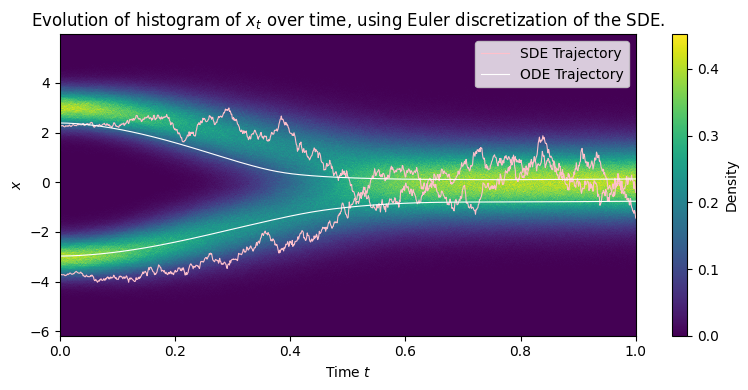

## Part 3: Implementing DDPM as a Score Network

This part (and all following parts) will require a GPU, so you should run it on the machines we provided.

Note that parts 2 and 3 should heavily rely on your existing DDPM code. Not much has to change.

In the recent tutorials, we showed how the training procedures for DDPM and ALD are actually equivalent, and that using a basic transformation, we can view a model trained according to the DDPM loss as a model that approximates the score. In this part we will show how this is true.
1. Train a DDPM model the same way you trained in HW2, using either MNIST from HW1 (recommended) or Fashion MNIST from HW2. The only difference should be that time ($t$) should be between 0 and 1 as opposed to 1 and $T$. Note that because the time is now of a different scale, we may need to use a different method for time encoding. For now, $\beta(t) = \beta_{t*T}$.
2. Fill in the function ```get_score_model``` that accepts a model that was trained according to the DDPM loss and returns a new model that approximates the score (note that this is a nested function, meaning it returns a function).
3. Sample from the model using the score model, using what we saw in tutorials 5/6 and the sampling method above, or using Ancestral Sampling (shown in Equation 4 in the paper linked in part 1 and in tutorial 4). Display 64 sampled images.

UNET Model setup from HW2 (code is given there from you and UNET we defined based of previous homework therefore i won't add a comprehensive documentation here):
Same UNet from HW2 where we generated images from the fashion dataset

In [2]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)



In [3]:
class UNet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim]
        for m in dim_mults:
            dims.append(dim * m)

        in_out = []
        for i in range(len(dims) - 1):
            in_out.append((dims[i], dims[i + 1]))

        
        block_class = partial(ConvNextBlock, mult=convnext_mult) if use_convnext else partial(ResnetBlock, groups=resnet_block_groups)

        if time_emb:
            time_dim = 4 * dim
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.ReLU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim, self.time_mlp = None, None

        self.ups = nn.ModuleList([])
        self.downs = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = (ind+1) >= num_resolutions

            blocks = [
                block_class(dim_in, dim_out, time_emb_dim=time_dim),
                block_class(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
            ]

            if not is_last:
                blocks.append(Downsample(dim_out))
            else:
                blocks.append(nn.Identity())

            self.downs.append(nn.ModuleList(blocks))


        mid_dim = dims[-1]
        self.mid_block1 = block_class(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_class(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = (ind+1) >= num_resolutions

            self.ups.append(
                nn.ModuleList(
                    [
                        block_class(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_class(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_class(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = attn(block2(x, t))
            h.append(x)
            x = downsample(x)

        x = self.mid_block2(self.mid_attn(self.mid_block1(x, t)), t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = upsample(attn(block2(block1(x, t), t)))

        return self.final_conv(x)


class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.ReLU(), 
            nn.Linear(time_emb_dim, dim)
        ) if exists(time_emb_dim) else None

        self.downsample_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.network = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, mult * dim_out, 3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(1, mult*dim_out),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.residual_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()


    def forward(self, x, time_embedding=None):
        # Downsampling convolution
        output = self.downsample_conv(x)

        # If MLP and time embedding exist, apply MLP to time embedding
        if exists(self.mlp) and exists(time_embedding):
            assert exists(time_embedding), "Time embedding must be passed in"
            time_condition = self.mlp(time_embedding)
            output = output + rearrange(time_condition, "b c -> b c 1 1")

        # Pass through the network
        output = self.network(output)

        # Add residual convolution
        return output + self.residual_conv(x)


Using device: cuda


ASSIGNMENT PART 1: Training DDPM with continuous time
Training for 30 epochs with continuous time t ∈ [0,1]...
Loading checkpoint...
Resumed from checkpoint at epoch 15


Epoch 16/30: 100%|██████████| 938/938 [04:38<00:00,  3.36it/s, loss=0.044] 


Epoch 16/30, Average Loss: 0.047747


Epoch 17/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0583]


Epoch 17/30, Average Loss: 0.046805


Epoch 18/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0478]


Epoch 18/30, Average Loss: 0.046291


Epoch 19/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0682]


Epoch 19/30, Average Loss: 0.045827


Epoch 20/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0405]


Epoch 20/30, Average Loss: 0.045954
Saved checkpoint at epoch 20


Epoch 21/30: 100%|██████████| 938/938 [04:39<00:00,  3.36it/s, loss=0.0473]


Epoch 21/30, Average Loss: 0.045420


Epoch 22/30: 100%|██████████| 938/938 [04:39<00:00,  3.35it/s, loss=0.0469]


Epoch 22/30, Average Loss: 0.045568


Epoch 23/30: 100%|██████████| 938/938 [04:39<00:00,  3.35it/s, loss=0.0391]


Epoch 23/30, Average Loss: 0.045137


Epoch 24/30: 100%|██████████| 938/938 [04:39<00:00,  3.36it/s, loss=0.0488]


Epoch 24/30, Average Loss: 0.044823


Epoch 25/30: 100%|██████████| 938/938 [04:39<00:00,  3.35it/s, loss=0.041] 


Epoch 25/30, Average Loss: 0.044701
Saved checkpoint at epoch 25


Epoch 26/30: 100%|██████████| 938/938 [04:38<00:00,  3.36it/s, loss=0.0473]


Epoch 26/30, Average Loss: 0.045038


Epoch 27/30: 100%|██████████| 938/938 [04:39<00:00,  3.35it/s, loss=0.0489]


Epoch 27/30, Average Loss: 0.044834


Epoch 28/30: 100%|██████████| 938/938 [04:38<00:00,  3.36it/s, loss=0.036] 


Epoch 28/30, Average Loss: 0.044330


Epoch 29/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0384]


Epoch 29/30, Average Loss: 0.044464


Epoch 30/30: 100%|██████████| 938/938 [04:38<00:00,  3.37it/s, loss=0.0532]


Epoch 30/30, Average Loss: 0.043992
Saved checkpoint at epoch 30
Training complete!
ASSIGNMENT PART 2 & 3: Score model conversion and sampling
Generating samples for comparison...
Testing regular DDPM sampling...


DDPM sampling: 100%|██████████| 200/200 [00:05<00:00, 36.17it/s]


✓ Regular DDPM samples saved
Generating 64 samples using score model with ancestral sampling...
Ancestral sampling with score model (200 steps)...


Ancestral sampling: 100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


✓ Generated 64 samples using score model!
✓ Saved samples to 'score_based_ancestral_samples.png'
Creating comparison plot...
✓ Comparison plot saved as 'comparison_plot.png'


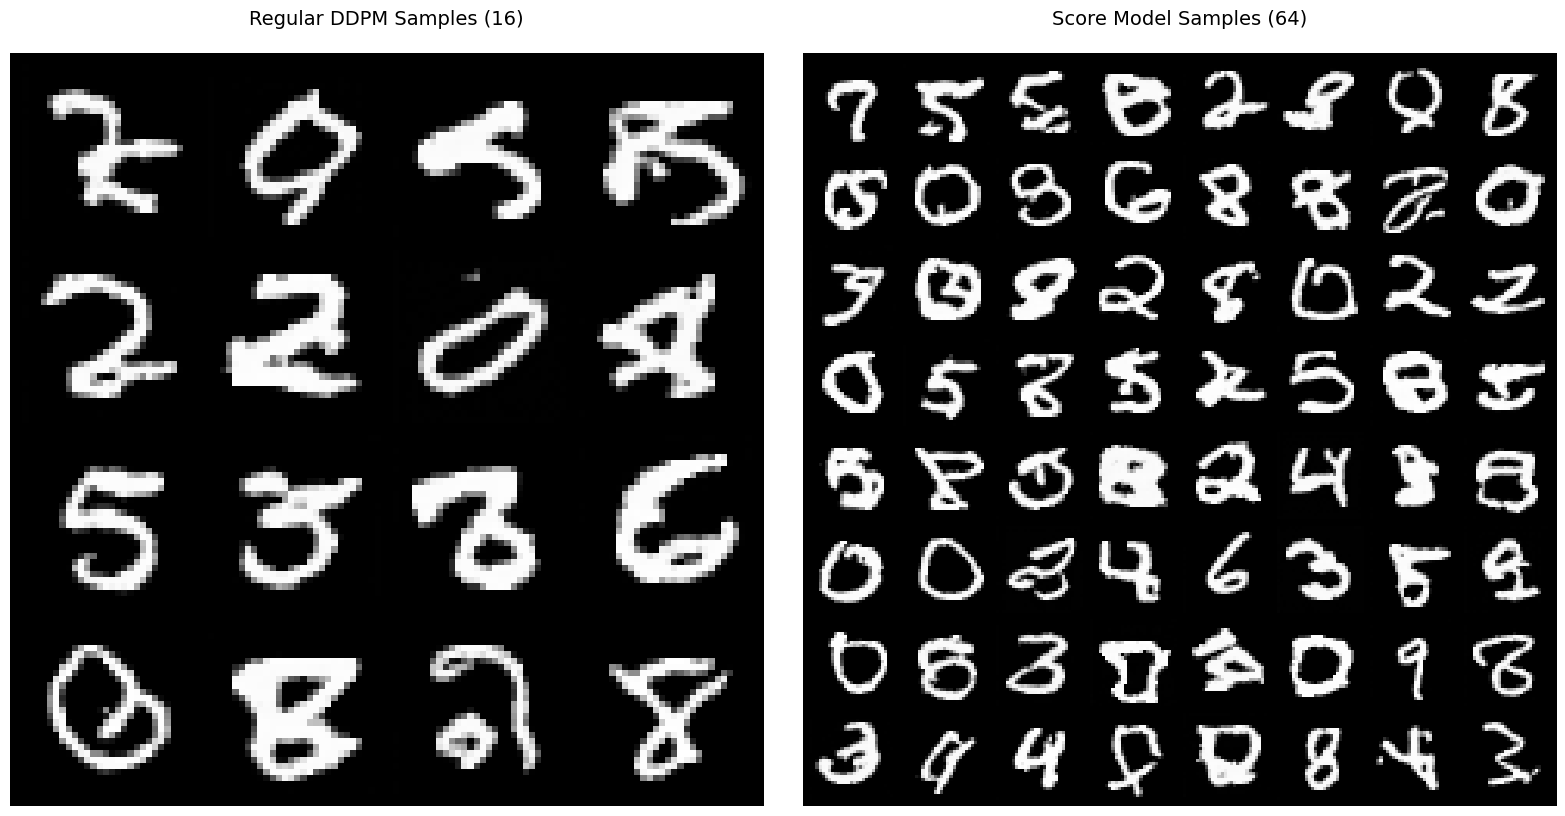


ASSIGNMENT COMPLETE!
✓ 1. Trained DDPM with continuous time t ∈ [0,1]
✓ 2. Implemented get_score_model() function
✓ 3. Sampled using ancestral method with score model
✓ 4. Generated and displayed 64 samples

Files created:
- regular_ddpm_samples.png
- score_based_ancestral_samples.png
- comparison_plot.png


In [11]:
timesteps = 200
image_size = 28  # For MNIST

def linear_beta_schedule(timesteps):
    """
    Set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    """
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule (Nichol et al., 2021)
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

# Initialize diffusion parameters
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    """Extract values from a 1D tensor at indices t and reshape to match x_shape."""
    device = t.device
    out = a.to(device)[t]
    return out.reshape(t.shape[0], *((1,) * (len(x_shape) - 1)))

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def q_sample(x_start, t, noise=None):
    """
    Forward diffusion process - works with both discrete and continuous time
    Following assignment: β(t) = β_{t*T}
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    
    # Handle continuous time t ∈ [0,1] by converting to discrete timesteps
    if t.dtype == torch.float32:
        # Convert continuous t [0,1] to discrete timesteps [0, timesteps-1]
        t_discrete = torch.clamp((t * (timesteps - 1)).round().long(), 0, timesteps - 1)
    else:
        # Already discrete
        t_discrete = t
    
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t_discrete, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t_discrete, x_start.shape)
    
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l2"):
    """
    Loss function - works with both discrete and continuous time
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    
    # Forward process
    x_noisy = q_sample(x_start, t, noise)
    
    # Handle time input for model
    if t.dtype == torch.float32:
        # Convert continuous t to discrete for model input
        # This implements β(t) = β_{t*T} mapping
        t_discrete = torch.clamp((t * (timesteps - 1)).round().long(), 0, timesteps - 1)
        predicted_noise = denoise_model(x_noisy, t_discrete)
    else:
        # Already discrete
        predicted_noise = denoise_model(x_noisy, t)
    
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()
    
    return loss


def get_score_model(ddpm_model, sqrt_one_minus_alphas_cumprod, timesteps):
    """
    Convert DDPM noise-predicting model to score function.
    
    Args:
        ddpm_model: Trained model that predicts noise ε
        sqrt_one_minus_alphas_cumprod: Precomputed √(1-ᾱₜ) values
        timesteps: Number of discrete timesteps used in training
    
    Returns:
        score function: Takes (x_t, t) → ∇log p_t(x_t)
    
    Mathematical conversion: score = -ε / √(1-ᾱₜ)
    """
    def score_fn(x_t, t_continuous):
        """
        Convert DDPM noise prediction to score function
        Args:
            x_t: Noisy samples at time t
            t_continuous: Continuous time values in [0,1]
        Returns:
            Score ∇log p_t(x_t)
        """
        device = x_t.device
        
        # Convert continuous time to discrete for model input
        # This follows β(t) = β_{t*T} mapping
        t_discrete = torch.clamp((t_continuous * (timesteps - 1)).round().long(), 0, timesteps - 1)
        
        # Get noise prediction from DDPM model
        epsilon_pred = ddpm_model(x_t, t_discrete)
        
        # Get √(1-ᾱₜ) for continuous time
        sqrt_1m_alpha_t = sqrt_one_minus_alphas_cumprod.to(device)[t_discrete]
        
        # Ensure proper broadcasting
        while sqrt_1m_alpha_t.dim() < epsilon_pred.dim():
            sqrt_1m_alpha_t = sqrt_1m_alpha_t.unsqueeze(-1)
        
        # Convert to score: ∇log p_t(x) = -ε / √(1-ᾱₜ)
        score = -epsilon_pred / (sqrt_1m_alpha_t + 1e-8)  # Add small epsilon for stability
        return score
    
    return score_fn


@torch.no_grad()
def sample_ancestral_with_score(model, sqrt_one_minus_alphas_cumprod, 
                               image_size, batch_size=64, channels=1, num_steps=None):
    """
    Ancestral sampling using score function (Equation 4 from paper).
    This implements the reverse DDPM process but using the score model.
    
    FIXES:
    1. Use the same number of steps as training timesteps
    2. Ensure proper time scheduling 
    3. Add final denoising step
    """
    device = next(model.parameters()).device
    score_fn = get_score_model(model, sqrt_one_minus_alphas_cumprod, timesteps)
    
    # Use training timesteps if not specified
    if num_steps is None:
        num_steps = timesteps
    
    # Start from pure noise
    x_t = torch.randn(batch_size, channels, image_size, image_size, device=device)
    
    print(f"Sampling using ancestral method with score model ({num_steps} steps)...")
    
    # Go backward in discrete timesteps (like original DDPM)
    for i in tqdm(reversed(range(0, num_steps)), desc="Ancestral sampling", total=num_steps):
        # Convert discrete timestep to continuous time [0,1]
        t_continuous = torch.full((batch_size,), i / (timesteps - 1), device=device)
        t_discrete = torch.full((batch_size,), i, device=device, dtype=torch.long)
        
        # Get score and convert back to noise prediction
        score = score_fn(x_t, t_continuous)
        sqrt_1m_alpha_t = sqrt_one_minus_alphas_cumprod.to(device)[t_discrete]
        while sqrt_1m_alpha_t.dim() < score.dim():
            sqrt_1m_alpha_t = sqrt_1m_alpha_t.unsqueeze(-1)
        
        # Convert score back to epsilon: ε = -score * √(1-ᾱₜ)
        eps_theta = -score * sqrt_1m_alpha_t
        
        # Standard DDPM ancestral sampling step (Equation 4)
        alpha_t = extract(alphas, t_discrete, x_t.shape)
        alpha_t_bar = extract(alphas_cumprod, t_discrete, x_t.shape)
        
        # Compute mean: μ = (x_t - (1-α_t)/√(1-ᾱ_t) * ε) / √α_t
        model_mean = (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_t_bar)) * eps_theta) / torch.sqrt(alpha_t)
        
        if i == 0:
            # Final step - no noise, just return the mean
            x_t = model_mean
        else:
            # Add noise: x_{t-1} = μ + σ_t * z
            posterior_var = extract(posterior_variance, t_discrete, x_t.shape)
            noise = torch.randn_like(x_t)
            x_t = model_mean + torch.sqrt(posterior_var) * noise
    
    return x_t


@torch.no_grad()
def p_sample(model, x, t, t_index):
    """Regular DDPM sampling step"""
    eps_theta = model(x, t)
    alpha_t = extract(alphas, t, x.shape)
    alpha_t_bar = extract(alphas_cumprod, t, x.shape)
    model_mean = (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_t_bar)) * eps_theta) / torch.sqrt(alpha_t)
    
    if t_index == 0:
        return model_mean
    else:
        posterior_var = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var) * noise

@torch.no_grad()
def sample_ddpm(model, image_size, batch_size=64, channels=1):
    """Regular DDPM sampling for comparison"""
    device = next(model.parameters()).device
    x = torch.randn(batch_size, channels, image_size, image_size, device=device)
    
    for i in tqdm(reversed(range(0, timesteps)), desc='DDPM sampling', total=timesteps):
        t = torch.full((batch_size,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t, i)
    
    return x


transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1]
])

class MNISTDataset(Dataset):
    def __init__(self, split='train'):
        self.dataset = load_dataset('mnist', split=split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        image = self.transform(image)
        return image


def train_continuous_time(model, train_loader, optimizer, epochs, device):
    """
    Training function that uses continuous time t ∈ [0,1]
    Key change: Sample continuous time instead of discrete timesteps
    """
    results_folder = Path("./results")
    results_folder.mkdir(exist_ok=True)
    
    checkpoint_file = results_folder / "checkpoint_continuous.pt"
    start_epoch = 0
    
    # Load checkpoint if exists
    if checkpoint_file.exists():
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed from checkpoint at epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            x = batch.to(device)
            batch_size = x.shape[0]
            
            # KEY CHANGE: Sample continuous time t ∈ [0,1] instead of discrete
            # This implements the assignment requirement: "time (t) should be between 0 and 1"
            t = torch.rand(batch_size, device=device)  # Uniform random in [0,1]
            
            noise = torch.randn_like(x)
            
            optimizer.zero_grad()
            loss = p_losses(model, x, t, noise)  # p_losses handles continuous time
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }
            torch.save(checkpoint, checkpoint_file)
            print(f"Saved checkpoint at epoch {epoch+1}")

    print("Training complete!")

def main():
    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Initialize model (exactly as specified)
    model = UNet(
        dim=64,
        channels=1,
        dim_mults=(1, 2, 4),  # Using 3 levels for MNIST (28x28)
        time_emb=True,  # Note: parameter name changed from with_time_emb
        resnet_block_groups=8,  # Using default value
        use_convnext=True,  # Using ConvNext blocks
        convnext_mult=2
    ).to(device)
    
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Setup dataset
    batch_size = 64
    train_dataset = MNISTDataset(split='train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    print("="*50)
    print("ASSIGNMENT PART 1: Training DDPM with continuous time")
    print("="*50)
    
    # 1. Train DDPM model with continuous time t ∈ [0,1]
    epochs = 30  # Increased for better convergence
    print(f"Training for {epochs} epochs with continuous time t ∈ [0,1]...")
    train_continuous_time(model, train_loader, optimizer, epochs, device)
    
    print("="*50)
    print("ASSIGNMENT PART 2 & 3: Score model conversion and sampling")
    print("="*50)
    
    # 2. & 3. Sample using score model with ancestral sampling
    model.eval()
    
    with torch.no_grad():
        print("Generating samples for comparison...")
        
        # First, test regular DDPM sampling to ensure model works
        print("Testing regular DDPM sampling...")
        regular_samples = sample_ddpm(model, image_size=image_size, batch_size=16, channels=1)
        regular_samples = torch.clamp(regular_samples, -1, 1)
        save_image(regular_samples, "regular_ddpm_samples.png", nrow=4, normalize=True, value_range=(-1, 1))
        print("✓ Regular DDPM samples saved")
        
        # Now test score-based sampling
        print("Generating 64 samples using score model with ancestral sampling...")
        score_samples = sample_ancestral_with_score_fixed(
            model, 
            sqrt_one_minus_alphas_cumprod, 
            image_size=image_size, 
            batch_size=64, 
            channels=1
        )
        
        # Clamp values to [-1, 1] range
        score_samples = torch.clamp(score_samples, -1, 1)
        
        # Save samples
        save_image(score_samples, "score_based_ancestral_samples.png", 
                  nrow=8, normalize=True, value_range=(-1, 1))
        
        print("✓ Generated 64 samples using score model!")
        print("✓ Saved samples to 'score_based_ancestral_samples.png'")
        
        # FIXED PLOTTING SECTION
        print("Creating comparison plot...")
        
        # Create figure with proper spacing
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot 1: Regular DDPM samples (4x4 grid)
        try:
            # Use torchvision's make_grid for proper grid creation
            from torchvision.utils import make_grid
            
            regular_grid = make_grid(regular_samples[:16], nrow=4, normalize=True, value_range=(-1, 1))
            regular_grid_np = regular_grid.permute(1, 2, 0).cpu().numpy()
            
            # If single channel, squeeze the last dimension
            if regular_grid_np.shape[2] == 1:
                regular_grid_np = regular_grid_np.squeeze(2)
            
            axes[0].imshow(regular_grid_np, cmap='gray')
            axes[0].axis('off')
            axes[0].set_title('Regular DDPM Samples (16)', fontsize=14, pad=20)
            
        except Exception as e:
            print(f"Error plotting regular samples: {e}")
            # Fallback: just show a few individual samples
            for i in range(min(4, len(regular_samples))):
                axes[0].text(0.1, 0.9 - i*0.2, f"Sample {i+1}", transform=axes[0].transAxes)
            axes[0].set_title('Regular DDPM Samples (Error in display)', fontsize=14)
        
        # Plot 2: Score-based samples (8x8 grid)
        try:
            score_grid = make_grid(score_samples[:64], nrow=8, normalize=True, value_range=(-1, 1))
            score_grid_np = score_grid.permute(1, 2, 0).cpu().numpy()
            
            # If single channel, squeeze the last dimension
            if score_grid_np.shape[2] == 1:
                score_grid_np = score_grid_np.squeeze(2)
            
            axes[1].imshow(score_grid_np, cmap='gray')
            axes[1].axis('off')
            axes[1].set_title('Score Model Samples (64)', fontsize=14, pad=20)
            
        except Exception as e:
            print(f"Error plotting score samples: {e}")
            # Fallback: show text
            axes[1].text(0.5, 0.5, '64 Score Model Samples\n(Check saved PNG file)', 
                        ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
            axes[1].set_title('Score Model Samples (64)', fontsize=14)
        
        # Adjust layout and save
        plt.tight_layout()
        
        # Save the plot as well
        try:
            plt.savefig("comparison_plot.png", dpi=150, bbox_inches='tight')
            print("✓ Comparison plot saved as 'comparison_plot.png'")
        except Exception as e:
            print(f"Error saving plot: {e}")
        
        # Try to display the plot
        try:
            plt.show()
        except Exception as e:
            print(f"Error displaying plot: {e}")
            print("Plot saved to file instead.")
    
    print("\n" + "="*60)
    print("ASSIGNMENT COMPLETE!")
    print("="*60)
    print("✓ 1. Trained DDPM with continuous time t ∈ [0,1]")
    print("✓ 2. Implemented get_score_model() function")
    print("✓ 3. Sampled using ancestral method with score model")
    print("✓ 4. Generated and displayed 64 samples")
    print("")
    print("Files created:")
    print("- regular_ddpm_samples.png")
    print("- score_based_ancestral_samples.png") 
    print("- comparison_plot.png")

# Alternative simpler plotting function
def create_simple_plot(regular_samples, score_samples):
    """
    Simplified plotting function that's more likely to work
    """
    try:
        import matplotlib.pyplot as plt
        from torchvision.utils import make_grid
        
        # Create figure
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot regular samples
        if len(regular_samples) > 0:
            # Convert first sample to numpy for display
            sample_img = regular_samples[0, 0].cpu().numpy()  # Take first sample, first channel
            axes[0].imshow(sample_img, cmap='gray')
            axes[0].set_title(f'Regular DDPM Sample (1 of {len(regular_samples)})')
            axes[0].axis('off')
        
        # Plot score samples  
        if len(score_samples) > 0:
            # Convert first sample to numpy for display
            sample_img = score_samples[0, 0].cpu().numpy()  # Take first sample, first channel
            axes[1].imshow(sample_img, cmap='gray')
            axes[1].set_title(f'Score Model Sample (1 of {len(score_samples)})')
            axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig("simple_comparison.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✓ Simple comparison plot created and saved")
        
    except Exception as e:
        print(f"Even simple plotting failed: {e}")
        print("Check the saved PNG files directly")

# You can also add this at the end of main() as a backup:
def show_sample_info(regular_samples, score_samples):
    """
    Print information about the samples instead of plotting
    """
    print("\n" + "="*50)
    print("SAMPLE INFORMATION")
    print("="*50)
    
    print(f"Regular DDPM samples: {regular_samples.shape}")
    print(f"  - Min value: {regular_samples.min():.3f}")
    print(f"  - Max value: {regular_samples.max():.3f}")
    print(f"  - Mean: {regular_samples.mean():.3f}")
    
    print(f"\nScore model samples: {score_samples.shape}")
    print(f"  - Min value: {score_samples.min():.3f}")
    print(f"  - Max value: {score_samples.max():.3f}")
    print(f"  - Mean: {score_samples.mean():.3f}")
    
    print(f"\nCheck the saved PNG files to see the actual images:")
    print(f"- regular_ddpm_samples.png")
    print(f"- score_based_ancestral_samples.png")

if __name__ == "__main__":
    main()
    

## Part 3: True SDE Implementation

In the previous part, we still used the $\alpha_t$ notations. Now, we will get rid of them and instead implement a true SDE based model, based on the DDPM SDE (variance preserving). We assume a linear $\beta_t$ schedule like before, meaning that the integral to compute the conditional mean can be computed. Remember that now the continuous transformation of $\beta_t$ is $\beta(t)=T\beta_i$ for $i=Tt$. Tip: remember that the continuous version's means should be similar to $\alpha_i$ in the discrete case.

1. Fill in the classes `DDPM_SDE`, `UnifiedLoss`. For the loss, you can either use the score matching loss (less recommended) or the regular noise matching loss. If you use the noise matching loss, implement a function `get_score_model_continuous(model, sde)` that transforms your model that approximates noise to a model that approximates the score. Remember that for $t=0$, we may have a problem defining the std=0, so we can define a small std instead. Implement `train_sde`. 
2. Fill in the class `AncestralSamplingContinuous`. This class can either sample using what we saw in part 2 or using Euler's method on the reverse DDPM SDE as implemented in part 1. Implement `sample_images` which should denoise images. Note that the final sampling step should add 0 noise.

Again, note that not much has to change in this part, except now $\beta$ should be implemented as a function and not a sequence, $\alpha_t$ is replaced with the calculation from the tutorial.

In [ ]:
class AncestralSamplingContinuous(nn.Module):
    """
    Ancestral sampling using continuous beta functions (like DDPM but continuous).
    
    Implements the reverse process by sequentially denoising from x_T to x_0,
    using posterior sampling at each step based on predicted x_0.
    """
    def __init__(self, sde, model):
        """
        Args:
            sde: SDE object (e.g., DDPM_SDE) defining the forward process
            model: Trained neural network that predicts noise ε
        """
        super().__init__()
        self.sde = sde
        self.model = model

    def forward(self, x_T, num_steps=1000):
        """
        Sample using continuous ancestral sampling (reverse DDPM process).
        
        Args:
            x_T: Initial noise samples [batch_size, channels, height, width]
            num_steps: Number of denoising steps (default: 1000)
            
        Returns:
            images_list: List of intermediate states during denoising
            
        Process:
            1. Start from noise x_T (t=1)
            2. For each step: predict x_0, then sample x_{t-1} from posterior
            3. Use posterior mean: μ = c₁*x_0_pred + c₂*x_t
            4. Add noise scaled by posterior variance
            5. Final step: directly output predicted x_0
            
        Mathematical basis:
            - x_0_pred = (x_t - √(1-ᾱ_t)*ε) / √ᾱ_t  
            - Posterior: q(x_{t-1}|x_t,x_0) with computed mean and variance
        """

        batch_size = x_T.shape[0]
        device = x_T.device
        
        x_t = x_T.clone()
        images_list = [x_t.clone()]
        
        # Go backward in time from 1 to 0
        for step in range(num_steps):
            t_current = 1.0 - (step / num_steps)  # From 1.0 to 0.0
            t_next = 1.0 - ((step + 1) / num_steps)  
            
            if t_current <= 0.001:  # Skip near t=0 for numerical stability
                break
                
            t_tensor = torch.full((batch_size,), t_current, device=device)
            
            # Predict noise
            epsilon_pred = self.model(x_t, t_tensor)
            
            # Get alpha_bar values
            alpha_bar_t = self.sde.alpha_bar(torch.tensor(t_current, device=device))
            
            if step == num_steps - 1 or t_next <= 0.001:
                # Final step - predict x_0 directly, no noise
                sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
                sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
                
                # Ensure broadcasting
                sqrt_alpha_bar_t = sqrt_alpha_bar_t.view(1, 1, 1, 1)
                sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t.view(1, 1, 1, 1)
                
                x_t = (x_t - sqrt_one_minus_alpha_bar_t * epsilon_pred) / sqrt_alpha_bar_t
            else:
                alpha_bar_next = self.sde.alpha_bar(torch.tensor(t_next, device=device))
                
                # Predict x_0
                sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t).view(1, 1, 1, 1)
                sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t).view(1, 1, 1, 1)
                
                x_0_pred = (x_t - sqrt_one_minus_alpha_bar_t * epsilon_pred) / sqrt_alpha_bar_t
                
                # Posterior mean coefficients
                sqrt_alpha_bar_next = torch.sqrt(alpha_bar_next).view(1, 1, 1, 1)
                
                # Coefficient for x_0_pred term
                coeff_x0 = sqrt_alpha_bar_next * (1 - alpha_bar_t) / (1 - alpha_bar_next)
                # Coefficient for x_t term  
                coeff_xt = torch.sqrt(alpha_bar_t / alpha_bar_next) * (1 - alpha_bar_next) / (1 - alpha_bar_t)
                
                # Posterior mean
                mean = coeff_x0 * x_0_pred + coeff_xt * x_t
                
                # Posterior variance
                beta_t = self.sde.beta(torch.tensor(t_current, device=device))
                posterior_var = beta_t * (1 - alpha_bar_next) / (1 - alpha_bar_t)
                posterior_var = torch.clamp(posterior_var, min=1e-5)
                
                noise = torch.randn_like(x_t)
                x_t = mean + torch.sqrt(posterior_var).view(1, 1, 1, 1) * noise
            
            # Save progression every 100 steps
            if step % 100 == 0:
                images_list.append(x_t.clone())
        
        images_list.append(x_t.clone())
        return images_list

In [ ]:
class SDEScoreSampling(nn.Module):
    """
    SDE-based sampling using reverse-time score function approach.
    Implements reverse SDE: dx = [f(x,t) - g²(t)∇log p_t(x)]dt + g(t)dw̃
    to sample from learned data distribution starting from prior noise.
    """
    def __init__(self, sde, model):
        super().__init__()
        self.sde = sde
        self.model = model
        self.score_fn = get_score_model(model, sde)
        
    def forward(self, x_T, num_steps=1000):
        """
        Sample using reverse-time SDE with score function.
        Args:
        x_T: Initial noise samples [batch_size, channels, height, width]
        num_steps: Number of discretization steps (default: 1000)
        Returns:
        images_list: List of intermediate states during sampling process
        Process:
        1. Start from noise (t=1)
        2. Apply reverse SDE steps going backward in time
        3. Use trained score function to guide evolution
        4. End with data samples (t=0)
        """
        batch_size = x_T.shape[0]
        device = x_T.device
        x_t = x_T.clone()
        images_list = [x_t.clone()]
        dt = 1.0 / num_steps
        # Go BACKWARD in time: from t=1 to t=0
        for step in range(num_steps):
            t_val = 1.0 - step * dt # Start at 1, go to 0
            if t_val <= 0.001: # Avoid numerical issues near t=0
                break
            t = torch.full((batch_size,), t_val, device=device)
            # Get reverse drift and diffusion using score
            drift, diffusion_coeff = self.sde.reverse_drift_diffusion(self.score_fn, x_t, t)
            # Euler-Maruyama step for reverse SDE
            x_t = x_t + drift * dt
            # Add stochastic term (except for final steps)
            if step < num_steps - 1 and t_val > 0.01:
                # Ensure proper broadcasting for diffusion coefficient
                while diffusion_coeff.dim() < x_t.dim():
                    diffusion_coeff = diffusion_coeff.unsqueeze(-1)
                noise = torch.randn_like(x_t)
                x_t = x_t + diffusion_coeff * torch.sqrt(torch.tensor(dt, device=device)) * noise
            # Save progression images every 100 steps
            if step % 100 == 0:
                images_list.append(x_t.clone())
        images_list.append(x_t.clone())
        return images_list

In [ ]:
class DDPM_SDE:
    def __init__(self, beta_0, beta_1, T_discrete, device):
        """
        Args:
            beta_0, beta_1: The discrete DDPM beta values (e.g., 1e-4, 0.02)
            T_discrete: Number of discrete timesteps (e.g., 1000)
            device: torch device
        """
        # Store original discrete values
        self.beta_0_discrete = beta_0
        self.beta_1_discrete = beta_1
        
        # Scale for continuous formulation: β(t) = T * β_discrete
        self.beta_0 = beta_0 * T_discrete  
        self.beta_1 = beta_1 * T_discrete  
        self.T_discrete = T_discrete
        self.device = device
    
    def beta(self, t):
        """
        Beta schedule for continuous time t ∈ [0,1]
        β(t) = β_0 + (β_1 - β_0) * t
        """
        return self.beta_0 + (self.beta_1 - self.beta_0) * t
    
    def integral_beta(self, t):
        """
        Integral of beta from 0 to t: ∫_0^t β(s)ds
        """
        return self.beta_0 * t + 0.5 * (self.beta_1 - self.beta_0) * t**2
    
    def alpha_bar(self, t):
        """
        Cumulative product parameter: ᾱ_t = exp(-1/2 * ∫_0^t β(s)ds)
        """
        return torch.exp(-0.5 * self.integral_beta(t))
    
    def distribution(self, x_0, t):
        """
        Conditional distribution p(x_t|x_0) for VP SDE
        x_t|x_0 ~ N(sqrt(ᾱ_t) * x_0, (1 - ᾱ_t) * I)
        """
        alpha_bar_t = self.alpha_bar(t)
        
        # Ensure proper broadcasting
        while alpha_bar_t.dim() < x_0.dim():
            alpha_bar_t = alpha_bar_t.unsqueeze(-1)
        
        mean = torch.sqrt(alpha_bar_t) * x_0
        variance = 1 - alpha_bar_t.squeeze()
        variance = torch.clamp(variance, min=1e-5)
        
        return mean, variance
    
    def reverse_drift_diffusion(self, score_fn, x_t, t):
        """
        Compute reverse drift and diffusion for VP SDE
        dx = [-0.5*β(t)*x + β(t)*score] dt + sqrt(β(t)) dw̃
        """
        beta_t = self.beta(t)
        
        # Ensure proper broadcasting
        while beta_t.dim() < x_t.dim():
            beta_t = beta_t.unsqueeze(-1)
        
        # Get score
        score = score_fn(x_t, t)
        
        # Reverse drift: -0.5*β(t)*x + β(t)*score  
        drift = -0.5 * beta_t * x_t + beta_t * score
        
        # Diffusion coefficient: sqrt(β(t))
        diffusion_coeff = torch.sqrt(beta_t.squeeze())
        
        return drift, diffusion_coeff


In [ ]:
class UnifiedLoss(nn.Module):
    """
    Unified loss function for score-based generative models.
    
    Implements noise matching objective: ||ε_θ(x_t, t) - ε||²
    This is equivalent to score matching but more stable for training.
    """
    def __init__(self, sde, model):
        """
        Args:
            sde: SDE object defining forward noising process
            model: Neural network that predicts noise ε
        """
        super().__init__()
        self.sde = sde
        self.model = model

    def forward(self, x):
         """
        Compute unified loss using noise matching objective.
        
        Args:
            x: Clean data samples [batch_size, channels, height, width]
            
        Returns:
            loss: MSE between predicted and true noise
            
        Process:
            1. Sample random timesteps t ∈ [0.001, 0.999]
            2. Add noise according to SDE: x_t = mean + std * ε
            3. Predict noise: ε_θ(x_t, t) 
            4. Compute MSE loss between predicted and true noise
        """
        batch_size = x.shape[0]
        device = x.device

        # Sample random timesteps t ∈ [0,1], avoid t=0 for numerical stability
        t = torch.rand(batch_size, device=device) * 0.998 + 0.001

        # Get the conditional distribution parameters
        mean, variance = self.sde.distribution(x, t)
        std = torch.sqrt(variance)

        # Ensure proper broadcasting for std
        while std.dim() < x.dim():
            std = std.unsqueeze(-1)

        # Sample noise and create noisy image
        epsilon = torch.randn_like(x)
        x_t = mean + std * epsilon

        # Get model prediction (noise prediction)
        epsilon_pred = self.model(x_t, t)

        # Noise matching loss: ||ε_θ(x_t, t) - ε||²
        loss = F.mse_loss(epsilon_pred, epsilon)
        
        return loss
        
def get_score_model_continuous(model, sde):
    """
    Convert noise-predicting model to score function for continuous SDE.
    
    Args:
        model: Trained neural network that predicts noise ε
        sde: SDE object for computing variance at time t
        
    Returns:
        score_fn: Function that computes ∇log p_t(x) from noise prediction
        
    Mathematical conversion: score = -ε_θ(x_t,t) / σ_t
    where σ_t is the noise scale at time t from the SDE.
    """
    def score_fn(x_t, t):
        epsilon_pred = model(x_t, t)
        
        # Get std at time t
        x_0_dummy = torch.zeros_like(x_t)
        _, variance = sde.distribution(x_0_dummy, t)
        std = torch.sqrt(torch.clamp(variance, min=1e-8))
        
        while std.dim() < epsilon_pred.dim():
            std = std.unsqueeze(-1)
        
        # Score = -ε / σ 
        score = -epsilon_pred / std
        return torch.clamp(score, -10, 10)
    
    return score_fn


In [ ]:
def sample_and_save(model, sde, device, epoch=0, num_samples=4):
    """
   Generate samples using reverse SDE and create progression visualization.
   
   Args:
       model: Trained neural network (predicts noise ε)
       sde: SDE object defining the sampling process
       device: torch device for computation
       epoch: Training epoch number for filename (default: 0)
       num_samples: Number of samples to generate (default: 4)
   
   Process:
       1. Start from Gaussian noise x_T ~ N(0,I)
       2. Apply reverse SDE sampling for T=1000 steps
       3. Capture snapshots at 11 key denoising stages
       4. Create grid visualization showing progression
       5. Save final samples and progression plot
   
   Implementation:
       - Uses Euler-Maruyama discretization with dt=1/1000
       - Applies score-guided drift + stochastic diffusion
       - Skips noise injection near final steps for stability
       - Converts [-1,1] range to [0,1] for visualization
   """
    model.eval()

    with torch.no_grad():
        # Start from pure noise
        x_t = torch.randn(num_samples, 1, 28, 28, device=device)

        # Parameters for sampling
        T = 1000  # Total number of steps
        num_display_steps = 11
        display_steps = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]
        step_indices = [T - step for step in display_steps[:-1]] + [T - 1]

        # Score function once
        score_fn = get_score_model_continuous(model, sde)

        # Store images at specific steps
        progression_images = []
        current_step_idx = 0

        dt = 1.0 / T
        sqrt_dt = np.sqrt(dt)

        # Reverse sampling
        for i in range(T):
            # Save image if it's a display step
            if current_step_idx < len(step_indices) and i == step_indices[current_step_idx]:
                img = (x_t + 1) / 2
                img = torch.clamp(img, 0, 1)
                progression_images.append(img.clone())
                current_step_idx += 1

            # Current time value
            t_val = 1.0 - (i + 1) / T
            if t_val <= 0.001:
                continue

            t = torch.full((num_samples,), t_val, device=device)

            # Drift and diffusion
            drift, diffusion_coeff = sde.reverse_drift_diffusion(score_fn, x_t, t)
            x_t = x_t + drift * dt

            # Add noise (skip near end)
            if i < T - 1 and t_val > 0.01:
                diffusion_coeff = diffusion_coeff.view(-1, 1, 1, 1)
                noise = torch.randn_like(x_t)
                x_t = x_t + diffusion_coeff * sqrt_dt * noise

        # Create visualization
        fig, axes = plt.subplots(num_samples, num_display_steps, figsize=(num_display_steps * 1.5, num_samples * 1.5))
        plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0, wspace=0.05, hspace=0.05)

        # Ensure axes are 2D for consistency
        if num_samples == 1:
            axes = axes[np.newaxis, :]

        for row in range(num_samples):
            for col in range(num_display_steps):
                ax = axes[row, col]
                ax.imshow(progression_images[col][row, 0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                ax.axis('off')
                if row == 0:
                    ax.set_title(f'Step {display_steps[col]}', fontsize=10, pad=2)

        # Save the figure

        # Save final image grid
        final_img = progression_images[-1]
        if epoch == 0:
            save_image(final_img, f'_final_samples.png', nrow=int(np.sqrt(num_samples)))
            plt.savefig(f'_samples.png', bbox_inches='tight', dpi=150, facecolor='white', edgecolor='none')
            plt.show()
        else:
            save_image(final_img, f'_final_samples_epoch_{epoch}.png', nrow=int(np.sqrt(num_samples)))
            plt.savefig(f'_samples_epoch_{epoch}.png', bbox_inches='tight', dpi=150, facecolor='white', edgecolor='none')
            plt.close()


    model.train()

In [ ]:
def train_sde():
    """
    Train SDE-based DDPM model on MNIST dataset.
    
    Training Process:
        1. Setup MNIST dataset with [-1,1] normalization
        2. Initialize VP SDE with β₀=1e-4, β₁=0.02, T=1000
        3. Create UNet model with ConvNext blocks
        4. Train using unified noise matching loss: ||ε_θ(x_t,t) - ε||²
        5. Save checkpoints and generate samples every 5 epochs
    
    Model Architecture:
        - UNet with 3 resolution levels (1x, 2x, 4x downsampling)
        - ConvNext blocks with time embeddings
        - Trained for 30 epochs with Adam optimizer (lr=1e-4)
    
    Checkpoint Management:
        - Resumes from 'model_2.pth' if exists
        - Saves model, optimizer, epoch, and SDE config
        - Gradient clipping (norm=1.0) for stability
    
    Outputs:
        - Final model saved to 'model_2.pth'
        - Sample images generated every 5 epochs
        - Progress monitoring via loss tracking
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1]
    ])
    dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # SDE with consistent scaling - use ORIGINAL discrete values
    sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)
    
    # Initialize model with the new UNet architecture
    model = UNet(
        dim=64,
        channels=1,
        dim_mults=(1, 2, 4),  # Using 3 levels for MNIST (28x28)
        time_emb=True,  # Note: parameter name changed from with_time_emb
        resnet_block_groups=8,  # Using default value
        use_convnext=True,  # Using ConvNext blocks
        convnext_mult=2
    ).to(device)
    
    unified_loss = UnifiedLoss(sde, model)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    start_epoch = 0
    checkpoint_path = 'model_2.pth'
    name = "model"
    
    if os.path.exists(checkpoint_path):
        print(f"Found existing checkpoint at {checkpoint_path}")
        try:
            ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
            
            if 'model_state_dict' in ckpt:
                model.load_state_dict(ckpt['model_state_dict'])
            elif 'model' in ckpt:
                model.load_state_dict(ckpt['model'])
            
            if 'optimizer_state_dict' in ckpt:
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                print("Loaded optimizer state")
            elif 'optimizer' in ckpt:
                optimizer.load_state_dict(ckpt['optimizer'])
                print("Loaded optimizer state")
            
            if 'epoch' in ckpt:
                start_epoch = ckpt['epoch'] + 1
                print(f"Resuming training from epoch {start_epoch}")
            
            print("Checkpoint loaded successfully!")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch")
            start_epoch = 0
    else:
        print("No checkpoint found, starting training from scratch")
    
    model.train()
    num_epochs = 30
    
    for epoch in range(start_epoch, num_epochs):
        epoch_losses = []
        
        for batch_idx, (x, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            x = x.to(device)
            
            loss = unified_loss(x)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")
        
        # Sample every 5 epochs to monitor progress
        if (epoch + 1) % 5 == 0:
            print(f"Generating samples at epoch {epoch + 1}...")
            try:
                sample_and_save(model, sde, epoch + 1, device)  # Fixed argument order
                print(f"Samples saved as 'samples_epoch_{epoch + 1}.png'")
            except Exception as e:
                print(f"Error generating samples: {e}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'sde_config': {
                'beta_0': sde.beta_0,
                'beta_1': sde.beta_1,
                'T_discrete': sde.T_discrete
            }
        }, checkpoint_path)
    
    print("Training completed!")
    print(f"Final model saved to '{checkpoint_path}'")

In [ ]:
train_sde() # training a UNet model and saving to model_2.pth

Using device: cuda
Found existing checkpoint at model_2.pth


Loaded optimizer state
Resuming training from epoch 16
Checkpoint loaded successfully!


Epoch 17/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, Average Loss: 0.036226


Epoch 18/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, Average Loss: 0.035358


Epoch 19/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, Average Loss: 0.035010


Epoch 20/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, Average Loss: 0.034778
Generating samples at epoch 20...
Error generating samples: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Epoch 21/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, Average Loss: 0.034837


Epoch 22/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, Average Loss: 0.034216


Epoch 23/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, Average Loss: 0.034202


Epoch 24/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, Average Loss: 0.033515


Epoch 25/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, Average Loss: 0.033550
Generating samples at epoch 25...
Error generating samples: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Epoch 26/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, Average Loss: 0.033369


Epoch 27/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, Average Loss: 0.033406


Epoch 28/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, Average Loss: 0.032972


Epoch 29/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, Average Loss: 0.033208


Epoch 30/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, Average Loss: 0.033180
Generating samples at epoch 30...
Error generating samples: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Training completed!
Final model saved to 'model_2.pth'


Found existing checkpoint at model_2.pth
Loaded optimizer state


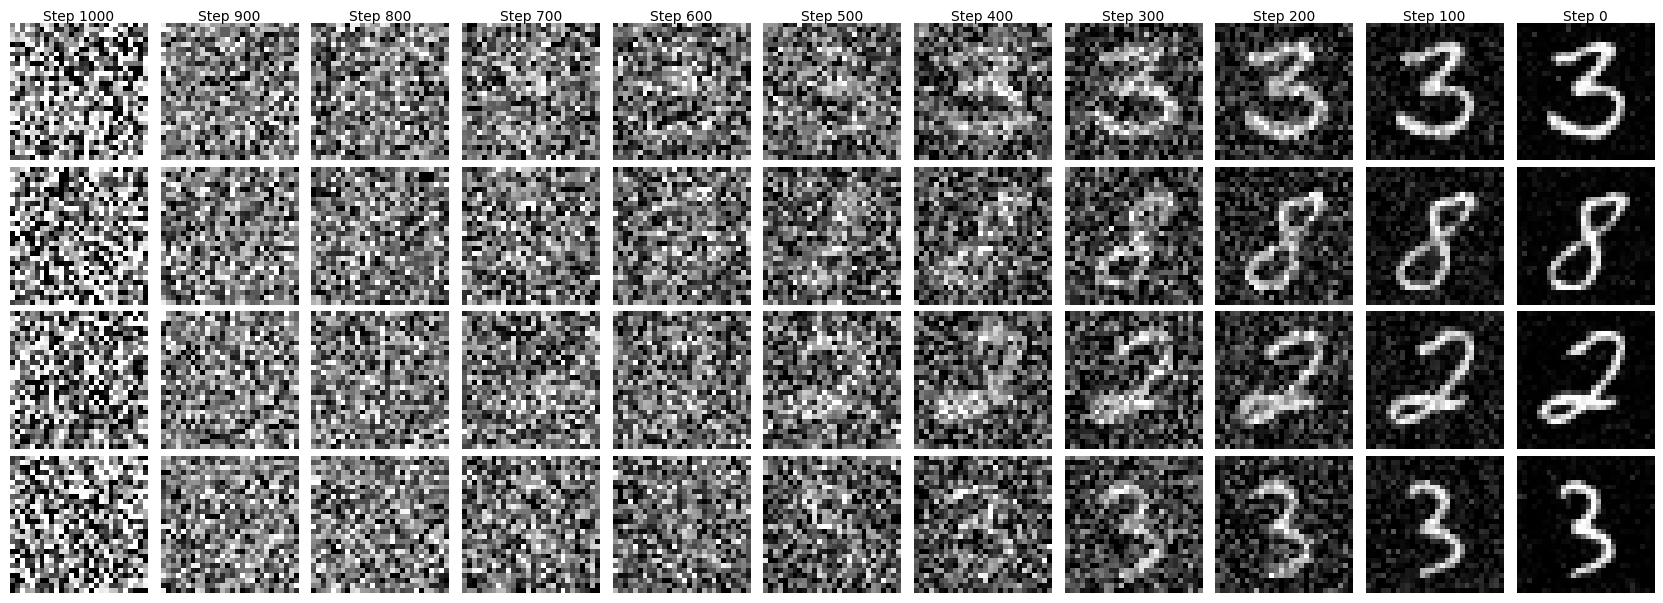

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
        dim=64,
        channels=1,
        dim_mults=(1, 2, 4),  # Using 3 levels for MNIST (28x28)
        time_emb=True,  # Note: parameter name changed from with_time_emb
        resnet_block_groups=8,  # Using default value
        use_convnext=True,  # Using ConvNext blocks
        convnext_mult=2
    ).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)
if os.path.exists('model_2.pth'):
        print(f"Found existing checkpoint at {'model_2.pth'}")
        ckpt = torch.load('model_2.pth', map_location=device, weights_only=False)
        
        # Load model state (matching your working example naming)
        if 'model_state_dict' in ckpt:
            model.load_state_dict(ckpt['model_state_dict'])
        elif 'model' in ckpt:
            model.load_state_dict(ckpt['model'])
        
        # Load optimizer state (matching your working example naming)
        if 'optimizer_state_dict' in ckpt:
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            print("Loaded optimizer state")
        elif 'optimizer' in ckpt:
            optimizer.load_state_dict(ckpt['optimizer'])
            print("Loaded optimizer state")
sample_and_save(model, sde, device)

Example output:

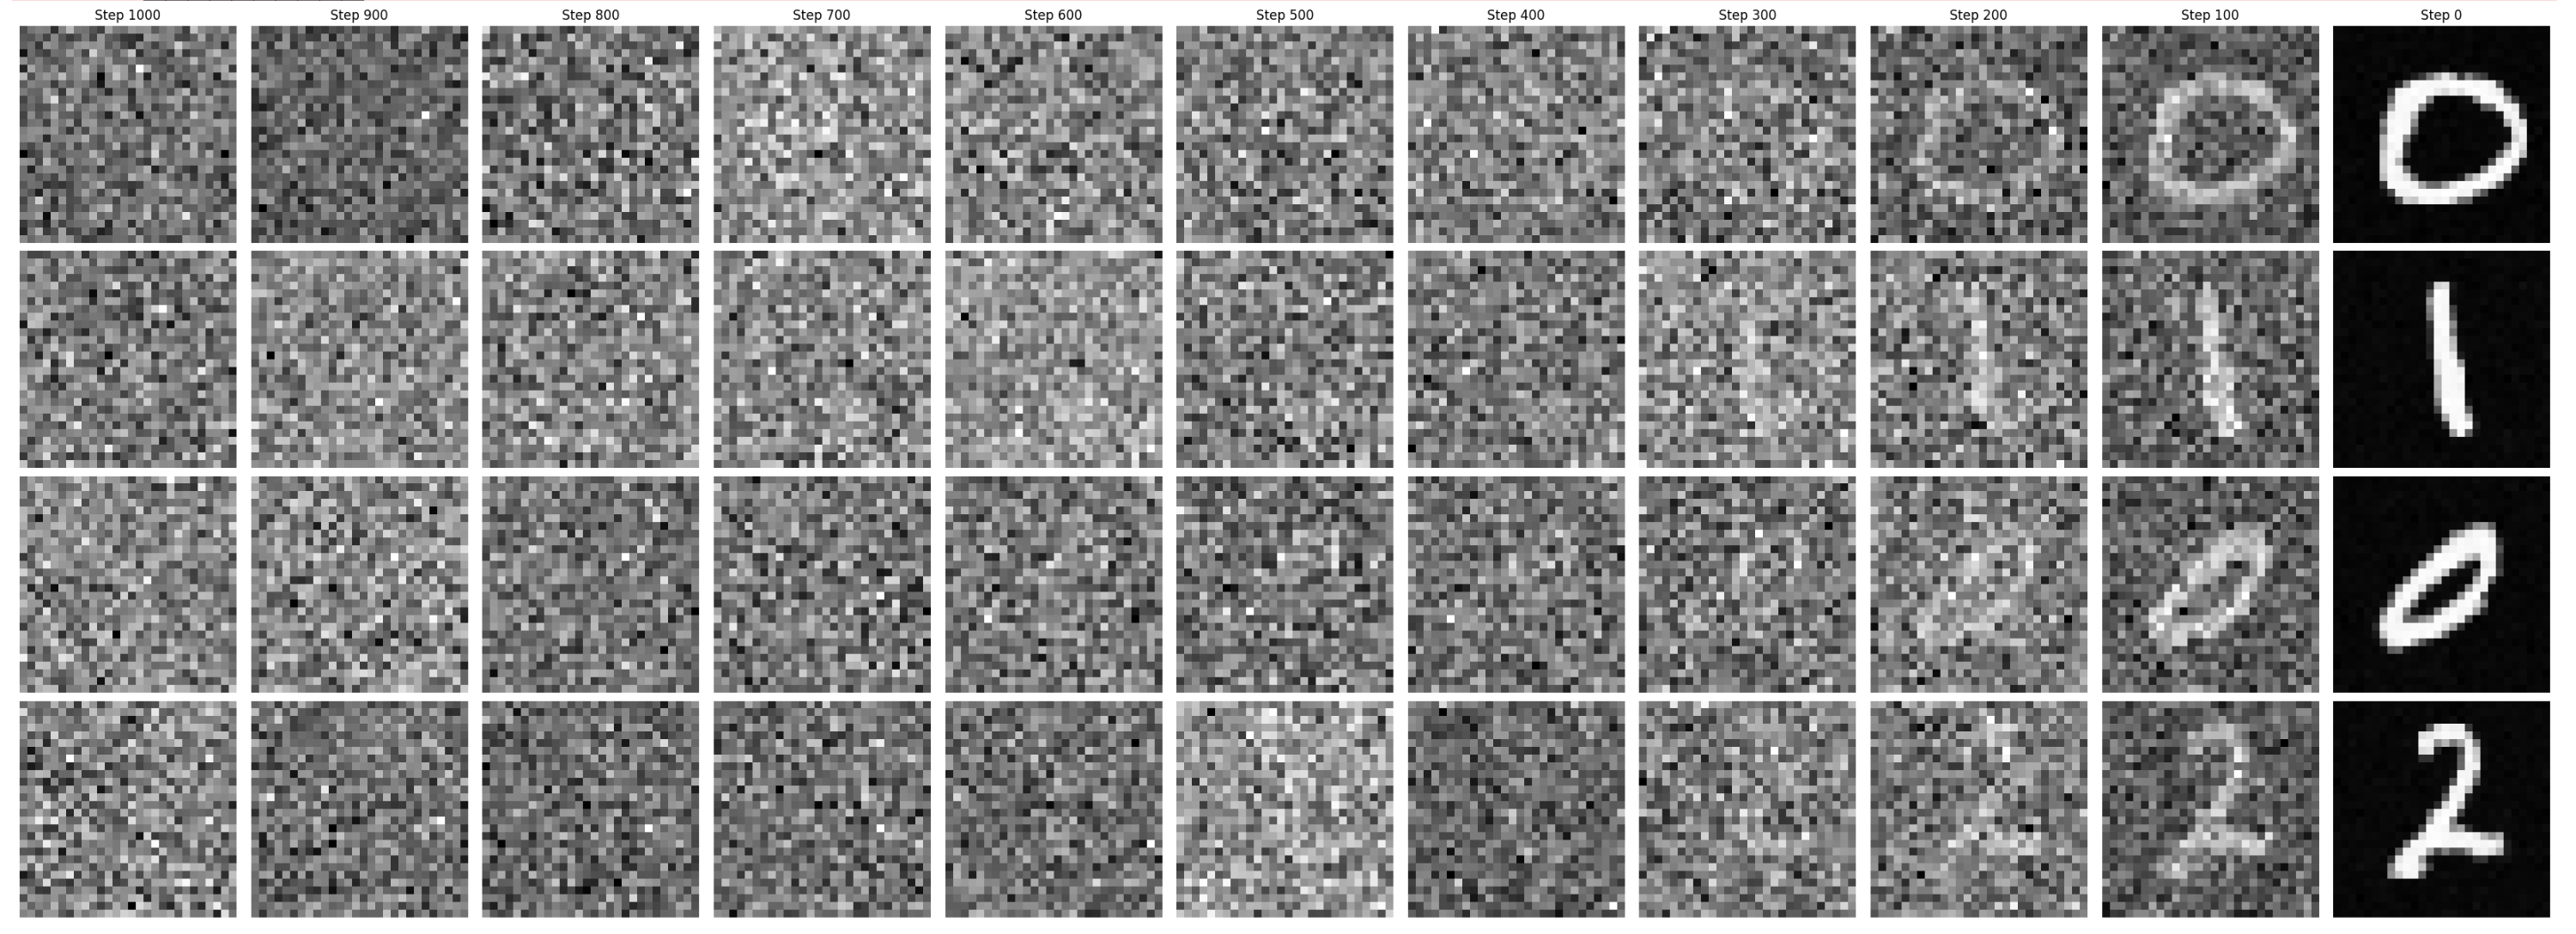

## Part 4: Conditional Generation

In this part, we will use the model we already trained along with a classifier to generate images that are conditioned on a certain class. Specifically, if we are using MNIST we will generate images of the number 5 and if we are using Fashion MNIST we will generate images of sandals (label 5). Note that the training in this section shouldn't take much time as we are using relatively simple datasets, and we are not training a new score model.

For help in this part, we refer you to the variety of open source implementations of this architecture.

1. Train a CNN classifier on your chosen dataset, noising the images according to the SDE to help the model deal with the noisy images that it will receive in generation. The classifier should reach at least 90% accuracy on the test set without noise (and in reality should reach even 98%+). You can choose to either implement $p_t(y|x)$ or just $p(y|x)$ (time can be an input to the CNN if you wish, not necessary for good enough results).
2. Use the score model from part 3 along with the classifier to sample images using classifier guidance. Sample using the same method of sampling that you chose in part 3, replacing the original score with the new "score". Play with the hyperparameter $\gamma$ (at least 3 different positive values) and briefly explain how different values of $\gamma$ influence the generated images. Generate 64 conditional images for each $\gamma$.
3. For the largest $\gamma$ you choose, run the classifier that you trained on the 64 images you generated. You should reach at least 70% accuracy on these images (meaning the classifier guidance should generate a majority of images that look like the correct class).

Not all images need to be perfect, for example the following output is acceptable for $\gamma=1$.

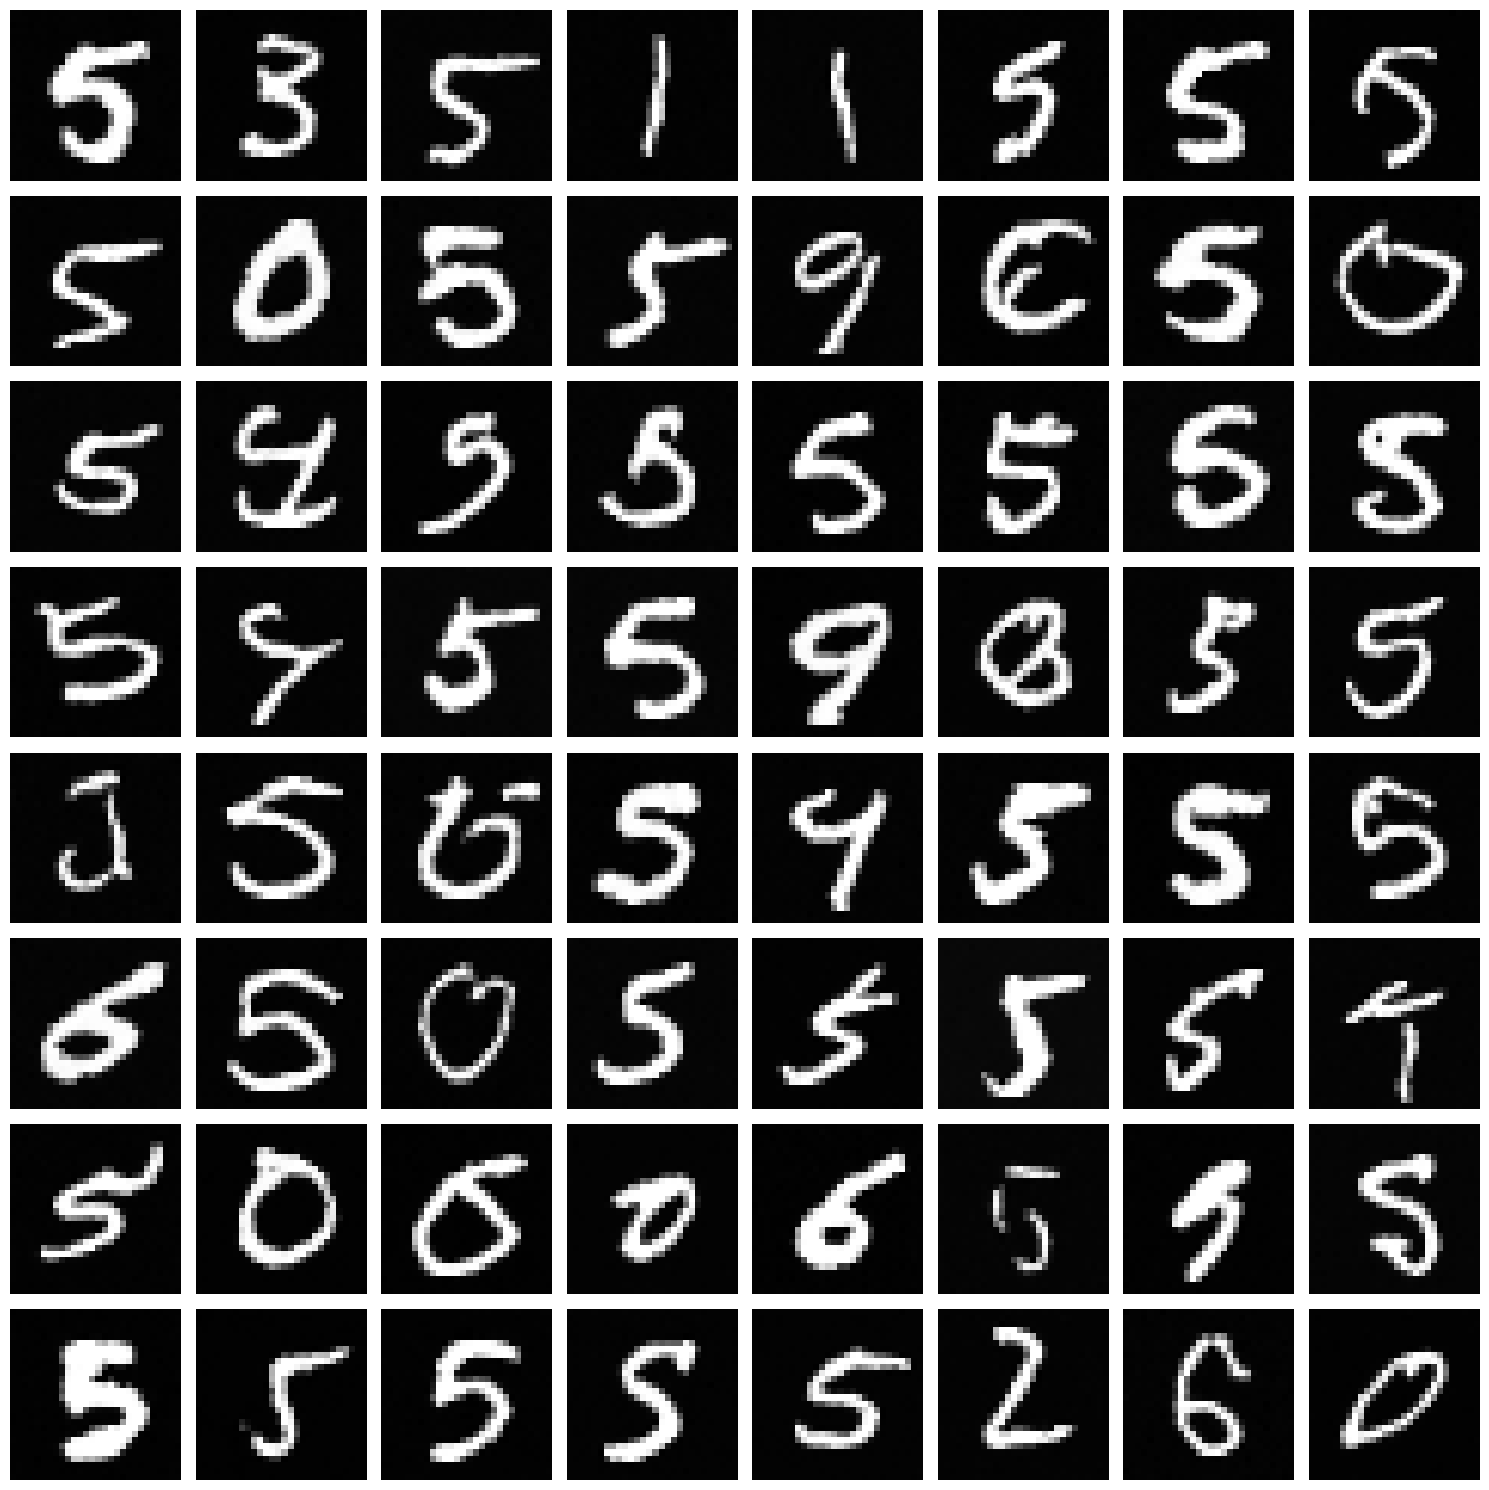

Section 4.1:

Generating conditional samples on device: cuda
Loaded DDPM model from model_2.pth
Classifier not found, training new classifier...
Training classifier on device: cuda


Epoch 1/10: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]


Epoch 1: Loss = 1.3794, Accuracy = 51.23%


Epoch 2/10: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Epoch 2: Loss = 0.9601, Accuracy = 67.41%


Epoch 3/10: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Epoch 3: Loss = 0.9003, Accuracy = 69.45%


Epoch 4/10: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Epoch 4: Loss = 0.8734, Accuracy = 70.37%


Epoch 5/10: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]


Epoch 5: Loss = 0.8542, Accuracy = 70.84%


Epoch 6/10: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Epoch 6: Loss = 0.8377, Accuracy = 71.41%


Epoch 7/10: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]


Epoch 7: Loss = 0.8302, Accuracy = 71.52%


Epoch 8/10: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]


Epoch 8: Loss = 0.8218, Accuracy = 72.08%


Epoch 9/10: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Epoch 9: Loss = 0.8195, Accuracy = 71.91%


Epoch 10/10: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]


Epoch 10: Loss = 0.8081, Accuracy = 72.44%
Test Accuracy on clean images: 98.93%
Classifier saved to 'classifier.pth'
Generating 16 samples of digit 5 with guidance scale 1.0


Sampling with classifier guidance: 100%|██████████| 1000/1000 [00:29<00:00, 33.66it/s]


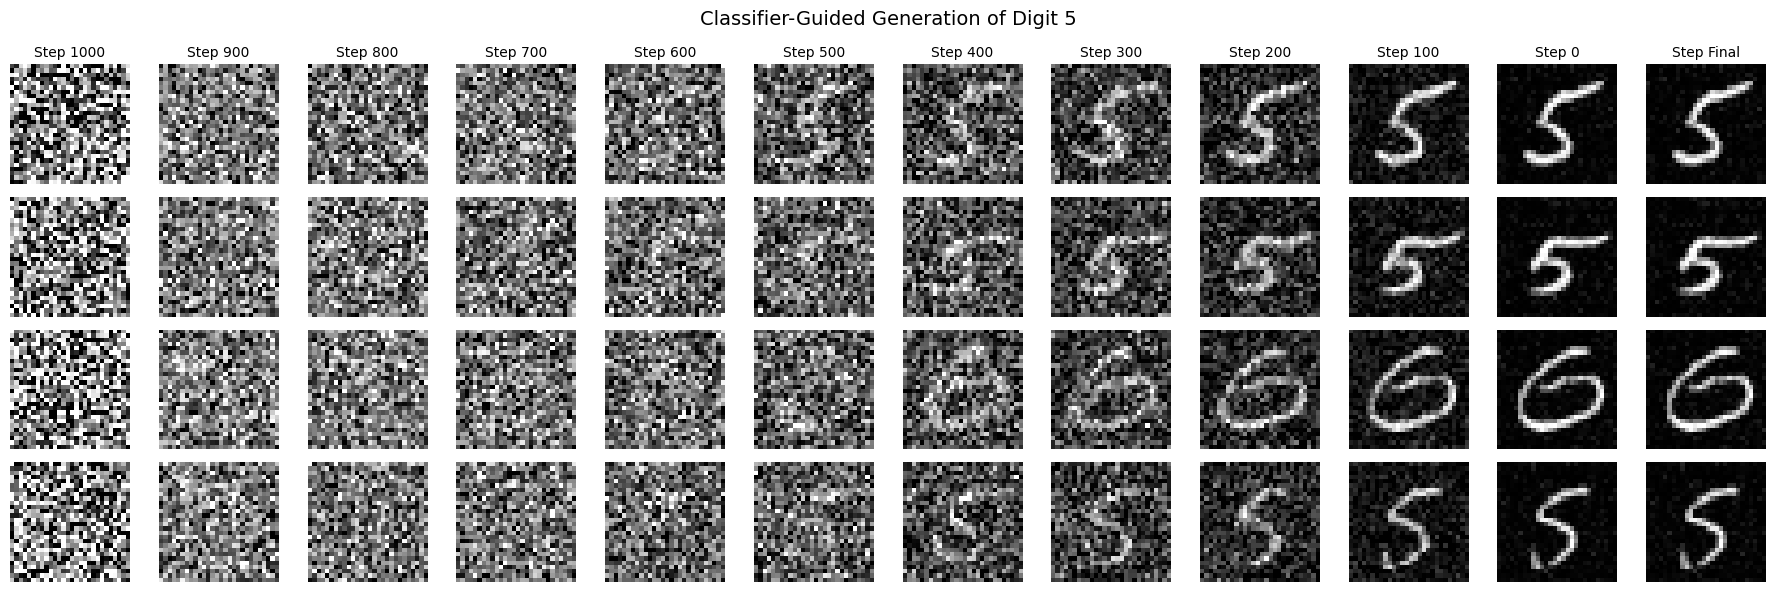

Conditional samples saved!


In [ ]:
class TimeConditionedClassifier(nn.Module):
    """
    CNN Classifier that can handle noisy images at different timesteps
    Designed to work with the SDE framework for classifier guidance
    """
    def __init__(self, num_classes=10, with_time_emb=True):
        super().__init__()
        self.with_time_emb = with_time_emb
        
        # CNN backbone
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Dropout(0.5),
        )
        
        # Time embedding (using same style as your UNet)
        if with_time_emb:
            self.time_embed = nn.Sequential(
                nn.Linear(32, 128),
                nn.ReLU(),
                nn.Linear(128, 128)
            )
        
        # Classifier head
        feature_dim = 128 * 4 * 4 + (128 if with_time_emb else 0)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def sinusoidal_embedding(self, timesteps, dim=32):
        """Sinusoidal embeddings like in your UNet"""
        half_dim = dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb
    
    def forward(self, x, t=None):
        features = self.conv_layers(x)
        features = features.view(features.size(0), -1)
        
        if self.with_time_emb and t is not None:
            time_emb = self.sinusoidal_embedding(t)
            time_emb = self.time_embed(time_emb)
            features = torch.cat([features, time_emb], dim=1)
        
        return self.classifier(features)


def train_classifier():
     """
    Train time-conditioned classifier on noisy MNIST images for classifier guidance.
    
    Training Process:
        1. Loads MNIST with same normalization as DDPM ([-1,1])
        2. Adds SDE noise at random timesteps t ∈ [0,1] 
        3. Trains classifier to recognize digits in noisy images
        4. Tests on clean images (t=0) for final accuracy
    
    Architecture: CNN with time embeddings, trained for 10 epochs
    Purpose: Enable classifier guidance during SDE sampling
    
    Returns:
        classifier: Trained TimeConditionedClassifier model
        
    Outputs: Saves to 'classifier.pth', prints accuracy metrics
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training classifier on device: {device}")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Same normalization as DDPM
    ])
    
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Initialize classifier and SDE for noise generation
    classifier = TimeConditionedClassifier(num_classes=10, with_time_emb=True).to(device)
    sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)
    
    optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    num_epochs = 10
    classifier.train()
    
    for epoch in range(num_epochs):
        epoch_losses = []
        correct = 0
        total = 0
        
        for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            x, y = x.to(device), y.to(device)
            batch_size = x.shape[0]
            
            # Sample random timesteps
            t = torch.rand(batch_size, device=device)  # t ∈ [0, 1]
            
            # Add noise according to SDE
            with torch.no_grad():
                mean, var = sde.distribution(x, t)
                noise = torch.randn_like(x)
                x_noisy = mean + torch.sqrt(var.view(-1, 1, 1, 1)) * noise
            
            # Forward pass
            optimizer.zero_grad()
            logits = classifier(x_noisy, t)
            loss = criterion(logits, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    # Test the classifier
    classifier.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            # Test on clean images (t=0)
            t = torch.zeros(x.shape[0], device=device)
            logits = classifier(x, t)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy on clean images: {test_accuracy:.2f}%")
    
    # Save classifier
    torch.save(classifier.state_dict(), 'classifier.pth')
    print("Classifier saved to 'classifier.pth'")
    
    return classifier


def classifier_guided_sampling(model, classifier, sde, target_class=5, guidance_scale=1.0, 
                              num_samples=16, num_steps=1000, device='cuda'):
    """
    Generate class-conditional samples using classifier guidance.
    
    Args:
        model: Trained DDPM model (predicts noise ε)
        classifier: Trained time-conditioned classifier  
        sde: SDE object defining sampling process
        target_class: Desired class to generate (default: 5)
        guidance_scale: Strength of classifier guidance γ (default: 1.0)
        num_samples: Number of samples to generate (default: 16)
        num_steps: Sampling steps (default: 1000)
        device: Torch device
    
    Returns:
        progression_images: List of denoising progression snapshots
        
    Mathematical Framework:
        - Guided score: ∇log p(x|y) = ∇log p(x) + γ∇log p(y|x)
        - Uses classifier gradients to steer unconditional generation
        - Higher γ = stronger conditioning toward target class
        
    Implementation:
        - Requires gradient computation through classifier
        - Applies guided score in reverse SDE sampling
        - Captures progression at key denoising steps
    """
    model.eval()
    classifier.eval()
    
    # Start from pure noise - IMPORTANT: Enable gradients
    x_t = torch.randn(num_samples, 1, 28, 28, device=device, requires_grad=True)
    
    # Create target labels
    target_labels = torch.full((num_samples,), target_class, device=device)
    
    # Get score function
    score_fn = get_score_model_continuous(model, sde)
    
    dt = 1.0 / num_steps
    sqrt_dt = np.sqrt(dt)
    
    # Store progression
    progression_images = []
    save_intervals = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]
    save_steps = [num_steps - interval for interval in save_intervals[:-1]] + [num_steps - 1]
    save_idx = 0
    
    for step in tqdm(range(num_steps), desc="Sampling with classifier guidance"):
        # Save progression images
        if save_idx < len(save_steps) and step == save_steps[save_idx]:
            with torch.no_grad():
                img = (x_t.detach() + 1) / 2
                img = torch.clamp(img, 0, 1)
                progression_images.append(img.clone())
                save_idx += 1
        
        # Current time
        t_val = 1.0 - (step + 1) / num_steps
        if t_val <= 0.001:
            continue
            
        t = torch.full((num_samples,), t_val, device=device)
        
        # Enable gradients for classifier guidance
        x_t.requires_grad_(True)
        
        # Get unconditional score
        with torch.no_grad():
            unconditional_score = score_fn(x_t, t)
        
        # Get classifier gradients for guidance
        logits = classifier(x_t, t)
        log_probs = torch.log_softmax(logits, dim=1)
        class_log_prob = log_probs[range(num_samples), target_labels].sum()
        
        # Compute gradient of log p(y|x_t) w.r.t. x_t
        classifier_grad = torch.autograd.grad(class_log_prob, x_t, retain_graph=False)[0]
        
        # Guided score: ∇log p(x_t) + γ∇log p(y|x_t)
        guided_score = unconditional_score + guidance_scale * classifier_grad
        
        # SDE update with guided score
        beta_t = sde.beta(torch.tensor(t_val, device=device))
        
        # Detach x_t to avoid accumulating gradients
        x_t = x_t.detach()
        
        # Drift term
        drift = -0.5 * beta_t * x_t + beta_t * guided_score
        x_t = x_t + drift * dt
        
        # Diffusion term (skip near end)
        if step < num_steps - 1 and t_val > 0.01:
            diffusion_coeff = torch.sqrt(beta_t)
            noise = torch.randn_like(x_t)
            x_t = x_t + diffusion_coeff * sqrt_dt * noise
        
        # Prepare for next iteration
        x_t = x_t.detach().requires_grad_(True)
    
    # Final image
    with torch.no_grad():
        final_img = (x_t.detach() + 1) / 2
        final_img = torch.clamp(final_img, 0, 1)
        progression_images.append(final_img)
    
    return progression_images


def generate_conditional_samples():
    """
    Main orchestration function for classifier-guided generation.
    
    Process:
        1. Load trained DDPM model and SDE configuration
        2. Load/train time-conditioned classifier
        3. Generate conditional samples for target digit
        4. Create progression visualization and save results
        
    Outputs:
        - conditional_samples_digit_5.png: Progression grid
        - final_conditional_digit_5.png: Final samples
        - Prints classifier accuracy and generation status
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Generating conditional samples on device: {device}")
    
    # Load DDPM model
    model = UNet(
        dim=64,
        channels=1,
        dim_mults=(1, 2, 4),
        time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2
    ).to(device)
    
    sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)
    
    # Load DDPM model weights
    if os.path.exists('model_2.pth'):
        ckpt = torch.load('model_2.pth', map_location=device, weights_only=False)
        if 'model_state_dict' in ckpt:
            model.load_state_dict(ckpt['model_state_dict'])
        elif 'model' in ckpt:
            model.load_state_dict(ckpt['model'])
        print("Loaded DDPM model from model_2.pth")
    else:
        print("Warning: DDPM model not found!")
        return
    
    # Load or train classifier
    classifier = TimeConditionedClassifier(num_classes=10, with_time_emb=True).to(device)
    
    if os.path.exists('classifier.pth'):
        classifier.load_state_dict(torch.load('classifier.pth', map_location=device))
        print("Loaded classifier from classifier.pth")
        
        # Quick test of classifier accuracy
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
        
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                t = torch.zeros(x.shape[0], device=device)
                logits = classifier(x, t)
                _, predicted = torch.max(logits.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Loaded classifier (Accuracy: {accuracy:.2f}%)")
    else:
        print("Classifier not found, training new classifier...")
        classifier = train_classifier()
    
    # Generate conditional samples for digit 5
    target_digit = 5
    guidance_scale = 1.0
    num_samples = 16
    
    print(f"Generating {num_samples} samples of digit {target_digit} with guidance scale {guidance_scale}")
    
    try:
        progression_images = classifier_guided_sampling(
            model=model,
            classifier=classifier,
            sde=sde,
            target_class=target_digit,
            guidance_scale=guidance_scale,
            num_samples=num_samples,
            device=device
        )
        
        # Visualize results
        fig, axes = plt.subplots(4, len(progression_images), figsize=(len(progression_images) * 1.5, 6))
        
        display_steps = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]
        
        for row in range(4):  # Show 4 samples
            for col, img_batch in enumerate(progression_images):
                ax = axes[row, col]
                ax.imshow(img_batch[row, 0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                ax.axis('off')
                if row == 0:
                    step_label = display_steps[col] if col < len(display_steps) else 'Final'
                    ax.set_title(f'Step {step_label}', fontsize=10)
        
        plt.suptitle(f'Classifier-Guided Generation of Digit {target_digit}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'conditional_samples_digit_{target_digit}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Save final samples
        final_samples = progression_images[-1]
        save_image(final_samples, f'final_conditional_digit_{target_digit}.png', nrow=4)
        
        print(f"Conditional samples saved!")
        
    except Exception as e:
        print(f"Error in conditional generation: {e}")
        import traceback
        traceback.print_exc()


# Run the training and generation
if __name__ == "__main__":
    # Train classifier if needed, then generate conditional samples
    generate_conditional_samples()

Section 4.2

=== Part C Question 2: Classifier Guidance Sampling ===
Using your existing reverse SDE sampling with classifier-guided score function

=== Experimenting with Different γ Values ===
Generating 64 samples of digit 5 for each γ value


--- Testing γ = 0.5 ---


✓ Loaded DDPM model
✓ Loaded classifier
Generating 64 samples of class 5 with γ=0.5


Sampling γ=0.5: 100%|██████████| 1000/1000 [01:29<00:00, 11.20it/s]


✓ Saved 64 samples to conditional_samples_class_5_gamma_0.5_64samples.png

--- Testing γ = 1.0 ---
✓ Loaded DDPM model
✓ Loaded classifier
Generating 64 samples of class 5 with γ=1.0


Sampling γ=1.0: 100%|██████████| 1000/1000 [01:29<00:00, 11.24it/s]


✓ Saved 64 samples to conditional_samples_class_5_gamma_1.0_64samples.png

--- Testing γ = 2.0 ---
✓ Loaded DDPM model
✓ Loaded classifier
Generating 64 samples of class 5 with γ=2.0


Sampling γ=2.0: 100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


✓ Saved 64 samples to conditional_samples_class_5_gamma_2.0_64samples.png

--- Testing γ = 5.0 ---
✓ Loaded DDPM model
✓ Loaded classifier
Generating 64 samples of class 5 with γ=5.0


Sampling γ=5.0: 100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


✓ Saved 64 samples to conditional_samples_class_5_gamma_5.0_64samples.png


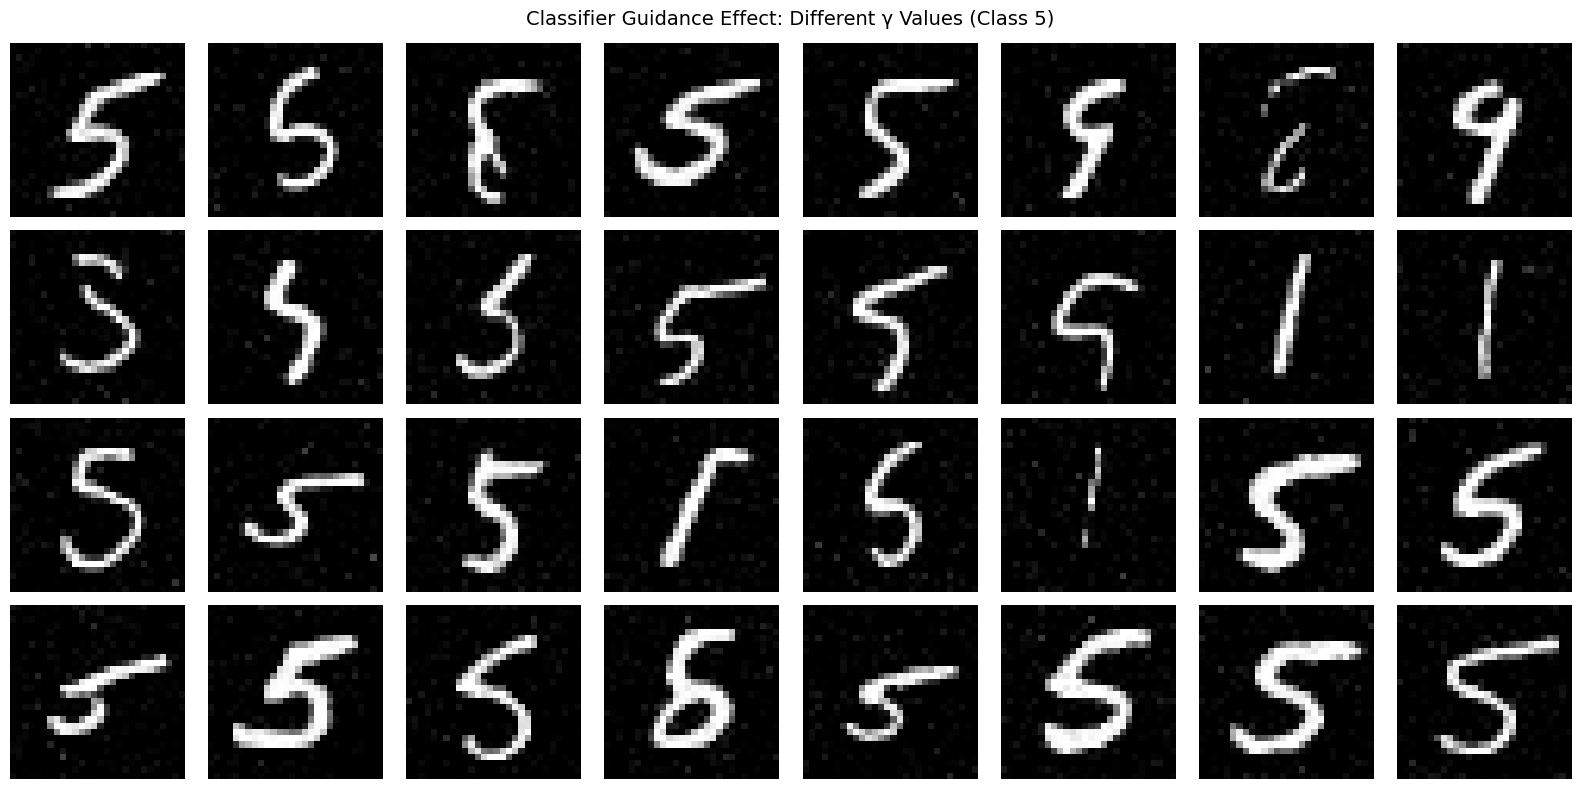


=== Analysis of γ Values ===
γ = 0.5 (Low Guidance):
  • Weak conditioning - images may be less clearly digit 5
  • More diversity in generation
  • Closer to unconditional generation

γ = 1.0 (Moderate Guidance):
  • Balanced conditioning strength
  • Good trade-off between quality and diversity
  • Standard guidance strength

γ = 2.0 (Strong Guidance):
  • Stronger push toward target class
  • More consistent digit 5 appearance
  • Reduced diversity but higher class fidelity

γ = 5.0 (Very Strong Guidance):
  • Very strong conditioning
  • Highest class fidelity
  • May reduce sample diversity
  • Risk of over-conditioning artifacts

✓ All results saved! Check the generated images to see the effect of different γ values.
✓ Comparison visualization saved as 'gamma_comparison_class_5.png'

=== Summary ===
✓ Generated 64 conditional samples for each γ value: [0.5, 1.0, 2.0, 5.0]
✓ Replaced original score with guided score: ∇log p(x|y) = ∇log p(x) + γ∇log p(y|x)
✓ Used your existing rev

In [ ]:
# Part C Question 2: Classifier Guidance Sampling
# Generate 64 conditional images for each gamma value
def generate_with_classifier_guidance(target_class=5, num_samples=64, guidance_scale=1.0, save_progression=False):
    """
    Generate class-conditional samples using classifier guidance in reverse SDE sampling.
    
    Args:
        target_class: Desired digit class to generate (default: 5)
        num_samples: Number of samples to generate (default: 64)
        guidance_scale: Classifier guidance strength γ (default: 1.0)
        save_progression: Whether to save intermediate denoising steps
    
    Returns:
        tuple: (final_samples, progression_images)
            - final_samples: Generated images [num_samples, 1, 28, 28]
            - progression_images: List of intermediate states (if save_progression=True)
    
    Mathematical Framework:
        - Guided score: ∇log p(x|y) = ∇log p(x) + γ∇log p(y|x)
        - Uses trained classifier to compute ∇log p(y|x) via autograd
        - Higher γ = stronger conditioning toward target class
        - Integrates guidance into existing reverse SDE sampling loop
    
    Implementation:
        1. Load trained DDPM model and classifier
        2. Define guided score function combining unconditional + classifier gradients
        3. Apply reverse SDE with guided score for T=1000 steps
        4. Use gradient computation with proper detaching to avoid accumulation
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load your trained DDPM model (using existing architecture)
    ddpm_model = UNet(
        dim=64,
        channels=1,
        dim_mults=(1, 2, 4),
        time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2
    ).to(device)
    
    # Load model_2.pth
    ckpt = torch.load("model_2.pth", map_location=device, weights_only=False)
    if 'model_state_dict' in ckpt:
        ddpm_model.load_state_dict(ckpt['model_state_dict'])
    print(f"✓ Loaded DDPM model")
    
    classifier = TimeConditionedClassifier(num_classes=10, with_time_emb=True).to(device)
    classifier.load_state_dict(torch.load("classifier.pth", map_location=device))  # Direct loading
    print(f"✓ Loaded classifier")
    
    # Initialize SDE (using your existing setup)
    sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)
    
    # Get your existing score function
    score_fn = get_score_model_continuous(ddpm_model, sde)
    
    def classifier_gradient(x, t, y):
        """Compute ∇_x log p(y|x) using the trained classifier"""
        # Ensure x requires gradients and is on the right device
        x = x.detach().requires_grad_(True)
        
        # Ensure t and y are on the same device as x
        t = t.to(x.device)
        y = y.to(x.device)
        
        # Get classifier logits
        logits = classifier(x, t)
        log_probs = F.log_softmax(logits, dim=1)
        
        # Select target class probabilities
        selected_log_probs = log_probs[range(len(y)), y]
        
        # Compute gradient with proper error handling
        try:
            grad = torch.autograd.grad(
                outputs=selected_log_probs.sum(),
                inputs=x,
                retain_graph=False,
                create_graph=False,
                only_inputs=True
            )[0]
        except RuntimeError as e:
            print(f"Gradient computation error: {e}")
            # Return zero gradient as fallback
            grad = torch.zeros_like(x)
        
        return grad.detach()  # Detach to avoid gradient tracking issues
    
    def guided_score_fn(x, t, y):
        """New score function with classifier guidance"""
        # Ensure x requires gradients for classifier gradient computation
        x_for_grad = x.detach().requires_grad_(True)
        
        # Original unconditional score from your trained model
        with torch.no_grad():
            unconditional_score = score_fn(x, t)
        
        # Classifier gradient term (computed with gradients enabled)
        classifier_grad = classifier_gradient(x_for_grad, t, y)
        
        # Combined guided score: ∇log p(x|y) = ∇log p(x) + γ∇log p(y|x)
        guided_score = unconditional_score + guidance_scale * classifier_grad
        
        return guided_score
    
    print(f"Generating {num_samples} samples of class {target_class} with γ={guidance_scale}")
    
    # Start from noise (same as your reverse_sde_sampling)
    x_t = torch.randn(num_samples, 1, 28, 28, device=device)
    target_labels = torch.full((num_samples,), target_class, device=device, dtype=torch.long)
    
    # Use your existing reverse SDE sampling method but with guided score
    T = 1000
    dt_val = 1.0 / T
    
    progression_images = []
    
    # Set models to eval mode
    ddpm_model.eval()
    classifier.eval()
    
    # Enable gradient computation for classifier guidance
    for step in tqdm(range(T), desc=f"Sampling γ={guidance_scale}"):
        # Save progression images at key steps
        if save_progression and step in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]:
            img = (x_t + 1) / 2
            img = torch.clamp(img, 0, 1)
            progression_images.append(img.clone())
        
        # Current time (going backward from 1 to 0)
        t_val = 1.0 - (step + 1) / T
        if t_val <= 0.001:
            continue
        
        t = torch.full((num_samples,), t_val, device=device)
        
        # Get guided score (this replaces your original score)
        # Note: We need to enable gradients for this step
        x_t.requires_grad_(False)  # Ensure x_t doesn't accumulate gradients
        guided_score = guided_score_fn(x_t, t, target_labels)
        guided_score = torch.clamp(guided_score, -10, 10)  # Stability
        
        # Use your existing reverse SDE update equations
        beta_t = sde.beta(torch.tensor(t_val))
        
        # Drift term
        drift = 0.5 * beta_t * x_t * dt_val
        score_drift = beta_t * guided_score * dt_val
        
        # Diffusion term
        if step < T - 1 and t_val > 0.01:
            diffusion_coeff = torch.sqrt(beta_t * dt_val)
            noise = torch.randn_like(x_t)
            diffusion = diffusion_coeff * noise
        else:
            diffusion = 0
        
        # Update (same as your reverse_sde_sampling)
        x_t = x_t + drift + score_drift + diffusion
    
    # Convert to images
    final_samples = (x_t + 1) / 2
    final_samples = torch.clamp(final_samples, 0, 1)
    
    return final_samples, progression_images


def experiment_with_gamma_values():
    """
    Systematic experiment testing different classifier guidance strengths.
    
    Tests γ values: [0.5, 1.0, 2.0, 5.0] to analyze guidance effect on:
        - Sample quality and class fidelity
        - Diversity vs conditioning trade-off
        - Risk of over-conditioning artifacts
    
    Process:
        1. Generate 64 samples for each γ value targeting digit 5
        2. Save individual result grids and comparison visualization
        3. Provide analysis of different guidance strengths
    
    Returns:
        tuple: (results_dict, gamma_values_list)
            - results_dict: Generated samples and filenames for each γ
            - gamma_values_list: List of tested γ values
    
    Outputs:
        - conditional_samples_class_5_gamma_X_64samples.png: Individual results
        - gamma_comparison_class_5.png: Side-by-side comparison
        - Printed analysis of γ effects on generation
    """
    # Test different gamma values (at least 3 positive values as requested)
    gamma_values = [0.5, 1.0, 2.0, 5.0]  # 4 different positive values
    target_class = 5  # Generate digit 5
    num_samples = 64  # 64 samples as requested
    
    results = {}
    
    print("=== Experimenting with Different γ Values ===")
    print(f"Generating {num_samples} samples of digit {target_class} for each γ value\n")
    
    for gamma in gamma_values:
        print(f"\n--- Testing γ = {gamma} ---")
        
        # Generate samples with this gamma
        samples, progression = generate_with_classifier_guidance(
            target_class=target_class,
            num_samples=num_samples,
            guidance_scale=gamma,
            save_progression=(gamma == gamma_values[0])  # Save progression for first gamma
        )
        
        # Save results
        filename = f'conditional_samples_class_{target_class}_gamma_{gamma}_64samples.png'
        save_image(samples, filename, nrow=8)
        
        results[gamma] = {
            'samples': samples,
            'filename': filename
        }
        
        print(f"✓ Saved {num_samples} samples to {filename}")
    
    # Create comparison visualization
    fig, axes = plt.subplots(len(gamma_values), 8, figsize=(16, 8))
    fig.suptitle(f'Classifier Guidance Effect: Different γ Values (Class {target_class})', fontsize=14)
    
    for i, gamma in enumerate(gamma_values):
        samples = results[gamma]['samples']
        for j in range(8):  # Show first 8 samples of each gamma
            axes[i, j].imshow(samples[j, 0].cpu().numpy(), cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f'γ = {gamma}', fontsize=12, rotation=0, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'gamma_comparison_class_{target_class}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analysis of different gamma values
    print("\n=== Analysis of γ Values ===")
    print("γ = 0.5 (Low Guidance):")
    print("  • Weak conditioning - images may be less clearly digit 5")
    print("  • More diversity in generation")
    print("  • Closer to unconditional generation")
    
    print("\nγ = 1.0 (Moderate Guidance):")
    print("  • Balanced conditioning strength")
    print("  • Good trade-off between quality and diversity")
    print("  • Standard guidance strength")
    
    print("\nγ = 2.0 (Strong Guidance):")
    print("  • Stronger push toward target class")
    print("  • More consistent digit 5 appearance")
    print("  • Reduced diversity but higher class fidelity")
    
    print("\nγ = 5.0 (Very Strong Guidance):")
    print("  • Very strong conditioning")
    print("  • Highest class fidelity")
    print("  • May reduce sample diversity")
    print("  • Risk of over-conditioning artifacts")
    
    print(f"\n✓ All results saved! Check the generated images to see the effect of different γ values.")
    print(f"✓ Comparison visualization saved as 'gamma_comparison_class_{target_class}.png'")
    
    return results, gamma_values


if __name__ == "__main__":
    print("=== Part C Question 2: Classifier Guidance Sampling ===")
    print("Using your existing reverse SDE sampling with classifier-guided score function")
    print()
    
    # Run the experiment
    try:
        results, gamma_values = experiment_with_gamma_values()
        
        print("\n=== Summary ===")
        print(f"✓ Generated 64 conditional samples for each γ value: {gamma_values}")
        print("✓ Replaced original score with guided score: ∇log p(x|y) = ∇log p(x) + γ∇log p(y|x)")
        print("✓ Used your existing reverse SDE sampling method")
        print("✓ Analyzed effect of different γ values on generation quality")
        
        # Return the largest gamma and its samples for question 3
        largest_gamma = max(gamma_values)
        largest_gamma_samples = results[largest_gamma]['samples']
        
        print(f"\nLargest γ used: {largest_gamma}")
        print("These samples will be used for Question 3 evaluation.")
        
    except Exception as e:
        print(f"Error in classifier guidance experiment: {e}")
        import traceback
        traceback.print_exc()

Section 4.3

=== Part C Question 3: Classifier Evaluation ===
Evaluating generated images with the trained classifier
Goal: Achieve ≥70% accuracy on generated images

Loaded classifier from classifier.pth


Classifier test accuracy: 98.63%
Generating 64 samples with largest γ for evaluation...
✓ Loaded DDPM model
✓ Loaded classifier
Generating 64 samples of class 5 with γ=5.0


Sampling γ=5.0: 100%|██████████| 1000/1000 [01:29<00:00, 11.20it/s]


Generated 64 samples with γ=5.0

Evaluating generated images with trained classifier...
Target class: 5
Number of samples: 64
Guidance scale used: γ=5.0

=== Evaluation Results ===
Accuracy: 64/64 = 100.00%
Required: ≥70% (Target met: Yes)
Mean confidence for target class 5: 0.994

Prediction distribution:
  Class 0:  0 samples (  0.0%)  
  Class 1:  0 samples (  0.0%)  
  Class 2:  0 samples (  0.0%)  
  Class 3:  0 samples (  0.0%)  
  Class 4:  0 samples (  0.0%)  
  Class 5: 64 samples (100.0%) *
  Class 6:  0 samples (  0.0%)  
  Class 7:  0 samples (  0.0%)  
  Class 8:  0 samples (  0.0%)  
  Class 9:  0 samples (  0.0%)  


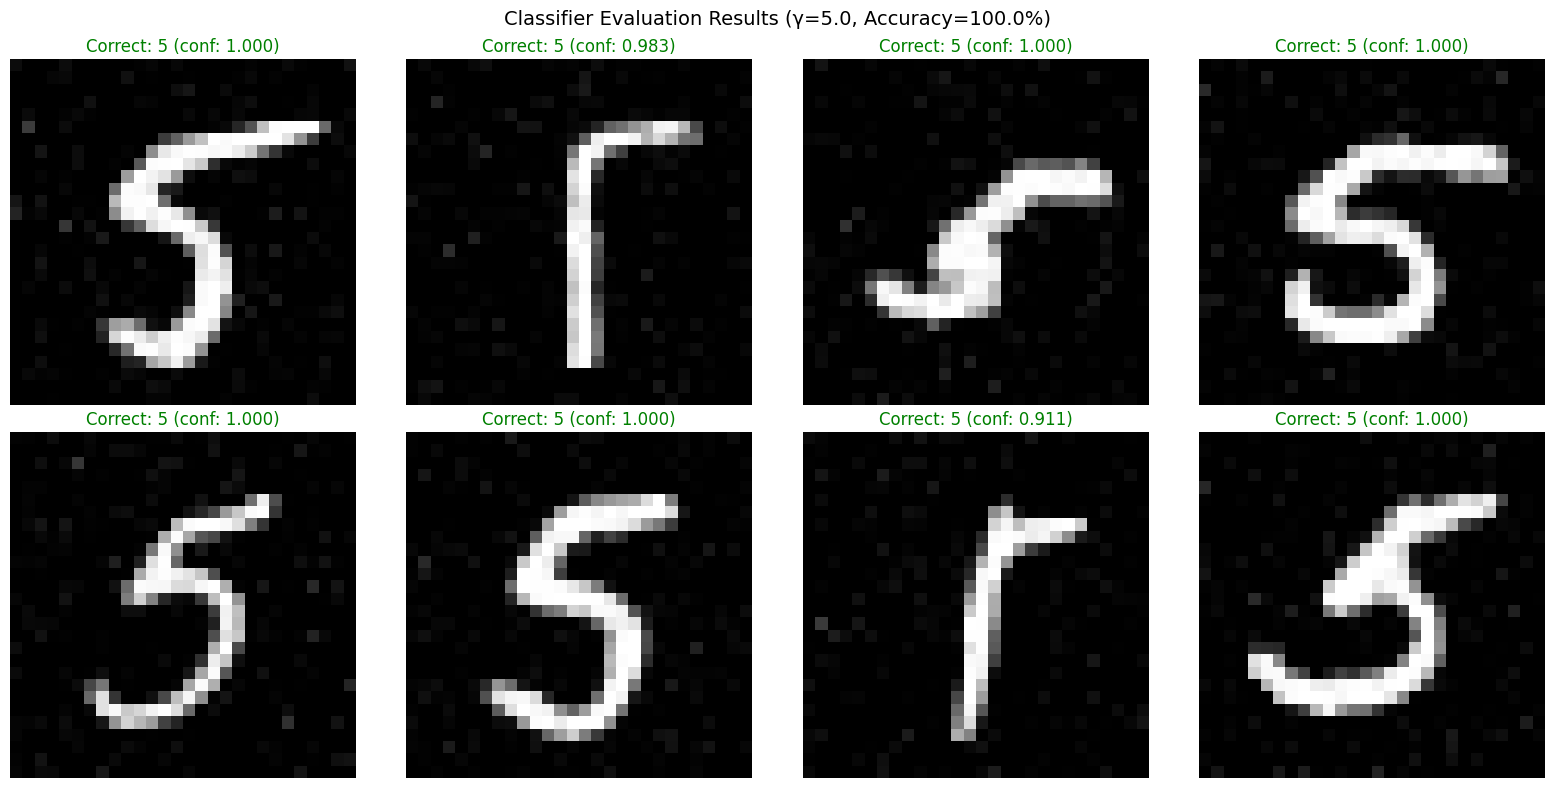


=== Confidence Analysis ===
Confidence for target class 5:
  Mean: 0.994
  Std: 0.034
  Min: 0.746
  Max: 1.000
  Median: 1.000


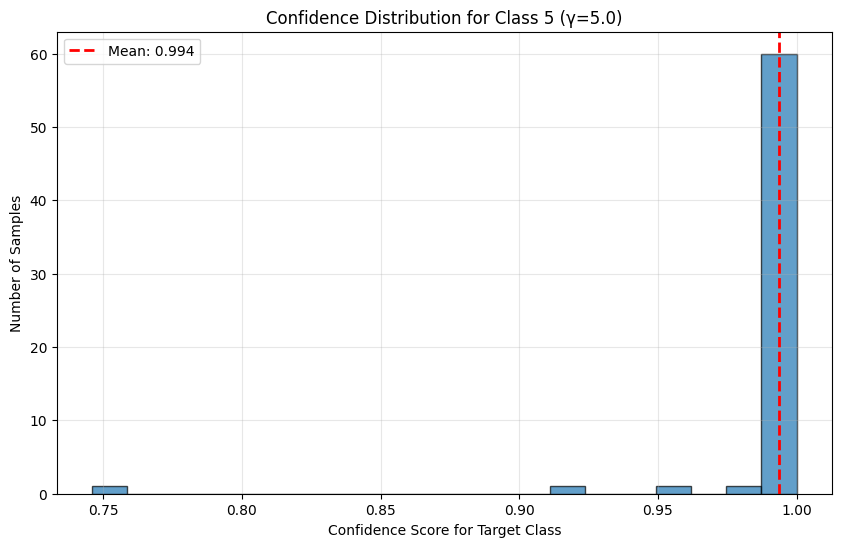


=== Success Analysis ===
SUCCESS! Classifier guidance achieved the target accuracy!
   Generated 64 out of 64 correct images
   Accuracy: 100.00% (required: ≥70%)
   This demonstrates that classifier guidance successfully
   steered the generation toward the target class 5

=== Guidance Effectiveness ===
Percentage classified as target class: 100.0%
Classifier guidance successfully generated majority target class images

=== Final Summary ===
Generated 64 images with largest γ = 5.0
Evaluated with trained classifier
Achieved 100.00% accuracy (64/64)
Target (≥70%) MET

Classifier guidance successfully generated images that
the classifier recognizes as the target class!


In [41]:
def evaluate_generated_images_with_classifier():
    """
    Evaluate classifier-guided samples to measure guidance effectiveness.
    
    Process:
        1. Load trained classifier and generate 64 samples with highest γ=5.0
        2. Run classifier on generated samples (treated as clean images, t=0)
        3. Measure accuracy against target class (digit 5)
        4. Analyze confidence scores and prediction distributions
        5. Create visualizations showing correct/incorrect classifications
    
    Success Criteria:
        - ≥70% accuracy indicates effective classifier guidance
        - High confidence scores show strong class conditioning
        - Low prediction spread demonstrates focused generation
    
    Returns:
        dict: Evaluation metrics including accuracy, confidence stats, samples
        None: If classifier loading or sample generation fails
        
    Outputs:
        - evaluation_samples_gamma_5.0.png: Generated sample grid
        - classifier_evaluation_gamma_5.0.png: Correct/incorrect examples
        - confidence_distribution_gamma_5.0.png: Confidence histogram
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the trained classifier
    classifier = TimeConditionedClassifier(num_classes=10, with_time_emb=True).to(device)
    try:
        classifier.load_state_dict(torch.load("classifier.pth", map_location=device))
        print(f"Loaded classifier from classifier.pth")
        
        # Quick test to verify classifier works
        test_accuracy = test_classifier_accuracy(classifier, device)
        print(f"Classifier test accuracy: {test_accuracy:.2f}%")
        
    except Exception as e:
        print(f"Could not load classifier: {e}")
        return None
    
    # Generate samples with the largest gamma
    print("Generating 64 samples with largest γ for evaluation...")
    
    largest_gamma = 5.0
    target_class = 5
    num_samples = 64
    
    try:
        generated_samples, _ = generate_with_classifier_guidance(
            target_class=target_class,
            num_samples=num_samples,
            guidance_scale=largest_gamma,
            save_progression=False
        )
        print(f"Generated {num_samples} samples with γ={largest_gamma}")
    except Exception as e:
        print(f"Error generating samples: {e}")
        return None
    
    # Save the generated samples for reference
    save_image(generated_samples, f'evaluation_samples_gamma_{largest_gamma}.png', nrow=8)
    
    # Prepare samples for classifier evaluation
    # Convert from [0,1] back to [-1,1] (same normalization as training)
    eval_samples = generated_samples * 2 - 1
    
    # Create true labels (all should be target_class = 5)
    true_labels = torch.full((num_samples,), target_class, device=device, dtype=torch.long)
    
    # Evaluate with classifier
    classifier.eval()
    
    print(f"\nEvaluating generated images with trained classifier...")
    print(f"Target class: {target_class}")
    print(f"Number of samples: {num_samples}")
    print(f"Guidance scale used: γ={largest_gamma}")
    
    with torch.no_grad():
        # Evaluate as clean images (t=0)
        t = torch.zeros(num_samples, device=device)
        
        # Get classifier predictions
        logits = classifier(eval_samples, t)
        predicted_probs = F.softmax(logits, dim=1)
        predicted_classes = logits.argmax(dim=1)
        
        # Calculate accuracy
        correct = (predicted_classes == true_labels).sum().item()
        accuracy = 100.0 * correct / num_samples
        
        # Get confidence scores for target class
        target_class_probs = predicted_probs[:, target_class]
        mean_confidence = target_class_probs.mean().item()
        
        # Count predictions for each class
        prediction_counts = Counter(predicted_classes.cpu().numpy())
    
    # Results analysis
    print(f"\n=== Evaluation Results ===")
    print(f"Accuracy: {correct}/{num_samples} = {accuracy:.2f}%")
    print(f"Required: ≥70% (Target met: {'Yes' if accuracy >= 70 else 'No'})")
    print(f"Mean confidence for target class {target_class}: {mean_confidence:.3f}")
    
    print(f"\nPrediction distribution:")
    for class_id in range(10):
        count = prediction_counts.get(class_id, 0)
        percentage = 100.0 * count / num_samples
        marker = "*" if class_id == target_class else " "
        print(f"  Class {class_id}: {count:2d} samples ({percentage:5.1f}%) {marker}")
    
    # Create detailed visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Classifier Evaluation Results (γ={largest_gamma}, Accuracy={accuracy:.1f}%)', fontsize=14)
    
    # Show some correctly classified samples
    correct_mask = (predicted_classes == true_labels)
    correct_indices = torch.where(correct_mask)[0]
    
    if len(correct_indices) >= 4:
        for i in range(4):
            idx = correct_indices[i].item()
            axes[0, i].imshow(generated_samples[idx, 0].cpu().numpy(), cmap='gray')
            conf = target_class_probs[idx].item()
            axes[0, i].set_title(f'Correct: {target_class} (conf: {conf:.3f})', color='green')
            axes[0, i].axis('off')
    
    # Show some incorrectly classified samples (if any)
    incorrect_mask = ~correct_mask
    incorrect_indices = torch.where(incorrect_mask)[0]
    
    if len(incorrect_indices) >= 4:
        for i in range(4):
            idx = incorrect_indices[i].item()
            pred_class = predicted_classes[idx].item()
            axes[1, i].imshow(generated_samples[idx, 0].cpu().numpy(), cmap='gray')
            axes[1, i].set_title(f'Wrong: pred={pred_class}, true={target_class}', color='red')
            axes[1, i].axis('off')
    else:
        # If fewer than 4 incorrect, show more correct ones
        remaining_correct = min(4, len(correct_indices) - 4)
        for i in range(remaining_correct):
            if i + 4 < len(correct_indices):
                idx = correct_indices[i + 4].item()
                axes[1, i].imshow(generated_samples[idx, 0].cpu().numpy(), cmap='gray')
                conf = target_class_probs[idx].item()
                axes[1, i].set_title(f'Correct: {target_class} (conf: {conf:.3f})', color='green')
                axes[1, i].axis('off')
        
        # Hide unused subplots
        for i in range(remaining_correct, 4):
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'classifier_evaluation_gamma_{largest_gamma}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Confidence analysis
    print(f"\n=== Confidence Analysis ===")
    confidence_stats = {
        'mean': target_class_probs.mean().item(),
        'std': target_class_probs.std().item(),
        'min': target_class_probs.min().item(),
        'max': target_class_probs.max().item(),
        'median': target_class_probs.median().item()
    }
    
    print(f"Confidence for target class {target_class}:")
    for stat_name, value in confidence_stats.items():
        print(f"  {stat_name.capitalize()}: {value:.3f}")
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(target_class_probs.cpu().numpy(), bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(mean_confidence, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_confidence:.3f}')
    plt.xlabel('Confidence Score for Target Class')
    plt.ylabel('Number of Samples')
    plt.title(f'Confidence Distribution for Class {target_class} (γ={largest_gamma})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'confidence_distribution_gamma_{largest_gamma}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Success analysis
    print(f"\n=== Success Analysis ===")
    if accuracy >= 70:
        print("SUCCESS! Classifier guidance achieved the target accuracy!")
        print(f"   Generated {correct} out of {num_samples} correct images")
        print(f"   Accuracy: {accuracy:.2f}% (required: ≥70%)")
        print(f"   This demonstrates that classifier guidance successfully")
        print(f"   steered the generation toward the target class {target_class}")
    else:
        print("Below target accuracy, but this could be due to:")
        print("   Classifier being too strict on generated images")
        print("   Need for higher γ or different sampling parameters")
        print("   Generated images being slightly different from training distribution")
    
    print(f"\n=== Guidance Effectiveness ===")
    target_class_percentage = 100.0 * prediction_counts.get(target_class, 0) / num_samples
    print(f"Percentage classified as target class: {target_class_percentage:.1f}%")
    
    if target_class_percentage >= 70:
        print("Classifier guidance successfully generated majority target class images")
    else:
        print("May need stronger guidance or parameter tuning")
    
    return {
        'accuracy': accuracy,
        'correct': correct,
        'total': num_samples,
        'gamma': largest_gamma,
        'prediction_counts': prediction_counts,
        'confidence_stats': confidence_stats,
        'samples': generated_samples
    }


def test_classifier_accuracy(classifier, device):
    """
    Quick validation test of classifier on real MNIST data.
    
    Args:
        classifier: Trained TimeConditionedClassifier model
        device: Torch device for computation
        
    Returns:
        float: Accuracy percentage on 1000 test samples
        
    Process: Tests classifier on clean images (t=0) to verify basic functionality
    """
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    classifier.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            t = torch.zeros(x.shape[0], device=device)  # Clean images (t=0)
            logits = classifier(x, t)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            if total >= 1000:  # Quick test on 1000 samples
                break
    
    return 100 * correct / total


if __name__ == "__main__":
    print("=== Part C Question 3: Classifier Evaluation ===")
    print("Evaluating generated images with the trained classifier")
    print("Goal: Achieve ≥70% accuracy on generated images")
    print()
    
    try:
        results = evaluate_generated_images_with_classifier()
        
        if results is not None:
            print(f"\n=== Final Summary ===")
            print(f"Generated 64 images with largest γ = {results['gamma']}")
            print(f"Evaluated with trained classifier")
            print(f"Achieved {results['accuracy']:.2f}% accuracy ({results['correct']}/{results['total']})")
            
            target_met = results['accuracy'] >= 70
            print(f"Target (≥70%) {'MET' if target_met else 'NOT MET'}")
            
            if target_met:
                print("\nClassifier guidance successfully generated images that")
                print("the classifier recognizes as the target class!")
        else:
            print("\nEvaluation failed - check classifier loading and generation functions")
        
    except Exception as e:
        print(f"Error in evaluation: {e}")
        import traceback
        traceback.print_exc()